In [1]:
import os
import os.path as osp
import pprint
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt
import scipy.io as sio

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.models.HT import hough_transform

from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to
import cv2
from IPython.display import Image, display
from scipy.spatial import distance as dist
from functools import cmp_to_key
import copy
from itertools import combinations
# from court_reference import CourtReference

In [2]:
REJECT_DEGREE_TH = 40.0

In [3]:
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [4]:
def c(x):
    return sm.to_rgba(x)

In [5]:
config_file = "config/wireframe.yaml"
C.update(C.from_yaml(filename=config_file))
M.update(C.model)
pprint.pprint(C, indent=4)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

{   'io': {   'datadir': 'data/wireframe/',
              'logdir': 'logs/',
              'num_workers': 4,
              'outdir': 'results/',
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_interval': 20000,
              'vote_index': 'vote_index_128_128_3_1.mat'},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 5,
                 'batch_size_eval': 2,
                 'depth': 4,
                 'dim_fc': 1024,
                 'dim_loi': 128,
                 'eval_junc_thres': 0.008,
                 'head_size': <BoxList: [[2], [1], [2]]>,
                 'image': {   'mean': <BoxList: [109.73, 103.832, 98.681]>,
                              'stddev': <BoxList: [22.275, 22.124, 23.229]>},
                 'loss_weight': {   'jmap': 8.0,
                                    'joff': 0.25,
                                    'lmap': 0.5,
                                    'lneg': 1,
            

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device_name = "cpu"
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(0)
print("Let's use", torch.cuda.device_count(), "GPU(s)!")

Let's use 0 GPU(s)!


In [7]:
device = torch.device(device_name)
checkpoint = torch.load("pretrained_models/ht_lcnn/checkpoint.pth.tar", map_location=device)


In [8]:
# Load model
if os.path.isfile(C.io.vote_index):
    vote_index = sio.loadmat(C.io.vote_index)['vote_index']
else:
    vote_index = hough_transform(rows=128, cols=128, theta_res=3, rho_res=1)
    sio.savemat(C.io.vote_index, {'vote_index': vote_index})
vote_index = torch.from_numpy(vote_index).float().contiguous().to(device)
print('load vote_index', vote_index.shape)

load vote_index torch.Size([128, 128, 182, 60])


In [9]:
model = lcnn.models.hg(
    depth=M.depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
    num_stacks=M.num_stacks,
    num_blocks=M.num_blocks,
    num_classes=sum(sum(M.head_size, [])),
    vote_index=vote_index,

)
model = MultitaskLearner(model)
model = LineVectorizer(model)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

LineVectorizer(
  (backbone): MultitaskLearner(
    (backbone): HourglassNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck2D(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (layer2): Sequential(
        (0): Bottleneck2D(
          (bn

In [10]:
img = "pictures/05.jpg"
print(f"Processing {img}")
im = skimage.io.imread(img)
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
gray = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]
cv2.imshow("img",gray)
# cv2.waitKey(0) 
# cv2.destroyAllWindows()
# display(Image(im))

Processing pictures/05.jpg


In [11]:
if im.ndim == 2:
    im = np.repeat(im[:, :, None], 3, 2)
im = im[:, :, :3]
im_resized = skimage.transform.resize(im, (512, 512)) * 255
image = (im_resized - M.image.mean) / M.image.stddev
# cv2.imshow("img",image)
# cv2.waitKey(0) 
image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()

In [12]:
# cv2.imshow("img",image)
# cv2.waitKey(0) 

In [13]:
with torch.no_grad():
    input_dict = {
        "image": image.to(device),
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    H = model(input_dict)["preds"]

In [14]:
lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
scores = H["score"][0].cpu().numpy()
print('lines: ',lines, ', scores: ', scores)
for i in range(1, len(lines)):
    if (lines[i] == lines[0]).all():
        lines = lines[:i]
        scores = scores[:i]
        break

lines:  [[[  30.22689009  383.60814452]
  [  49.91535582  384.06972289]]

 [[  30.22689009  383.60814452]
  [   2.80987517  415.34552574]]

 [[ 130.82459655  794.23868656]
  [  54.13813702  797.92921543]]

 ...

 [[ 362.87832159  775.8777678 ]
  [ 427.66825581  349.9882251 ]]

 [[ 281.281901     36.23759821]
  [ 257.12819132  443.90054047]]

 [[  46.7070749   969.20272112]
  [  15.21675611 1035.07992029]]] , scores:  [0.9991543 0.9991517 0.9990835 ... 0.6792506 0.679202  0.6783309]


In [15]:

# postprocess lines to remove overlapped lines
diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

In [16]:
type(nlines)

numpy.ndarray

In [17]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

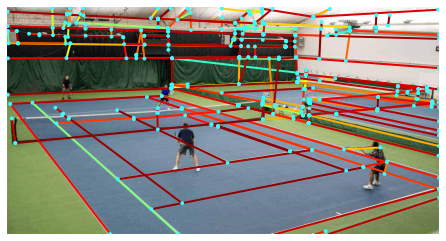

In [18]:
t = 0.94
im2 = np.copy(im)
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
    plt.scatter(a[1], a[0], **PLTOPTS)
    plt.scatter(b[1], b[0], **PLTOPTS)
    cv2.line(im2, (int(a[1]), int(a[0])), (int(b[1]), int(b[0])), (255, 255, 255), thickness=2)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()


In [19]:
cv2.imshow("OutputImage", im2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('pictures/test.jpg', im2)


True

In [20]:
perc = 0.1
remove = im.shape[0] * perc
remove_tp = True

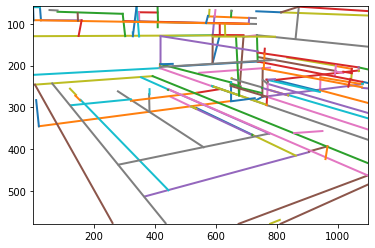

In [21]:
t = 0.94
plt.figure(1)
plt.margins(0, 0)
nlines2 = []
for (a, b), s in zip(nlines, nscores):
    if s < t or a[0] < remove or b[0] < remove:
        continue
    nlines2.append((a,b))
    plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
nlines2 = np.array(nlines2)
plt.gca().invert_yaxis()
plt.show()
plt.close()

(array([16.,  0.,  6., 10., 76., 33.,  2.,  0.,  3., 30.]), array([  0.24209723,  18.20700156,  36.17190588,  54.1368102 ,
        72.10171453,  90.06661885, 108.03152317, 125.9964275 ,
       143.96133182, 161.92623614, 179.89114047]), <BarContainer object of 10 artists>)


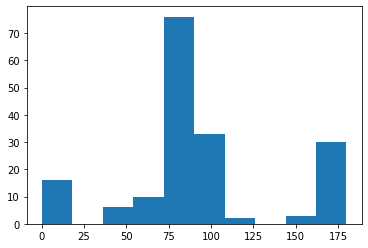

In [22]:
line_w_thetas = []
thetas=[]
for line in nlines2:
    if line[0][1]>line[1][1]:
        dy = line[0][1]-line[1][1]
        dx = line[0][0]-line[1][0]
    else:
        dy = line[1][1]-line[0][1]
        dx = line[1][0]-line[0][0]        

    theta = math.atan2(dy,dx)
    theta *= 180/math.pi
    line_w_thetas.append([line,theta])
    thetas.append(theta)
    # print (theta)
thetas.sort()
# print(thetas)
# np.gradient(thetas)
result = plt.hist(thetas)
print(result)

In [23]:
line_w_thetas[0][0]

array([[365.82223213, 720.00941038],
       [301.60399413, 536.71755791]])

In [24]:
res = np.copy(result[0])
print(res)
ind1=np.argmax(res)
res[ind1] =0
ind2 = np.argmax(res)
print(ind1,ind2)
print(result[1][ind1],result[1][ind2])
filter_th = [int(result[1][ind1]),int(result[1][ind2])]
print(filter_th)


[16.  0.  6. 10. 76. 33.  2.  0.  3. 30.]
4 5
72.10171452586657 90.0666188492874
[72, 90]


In [25]:
nlines2[0][0]

array([365.82223213, 720.00941038])

In [26]:
intersect_points = []
for i in range(len(nlines2)):
    for j in range(i+1,len(nlines2)):
        inter = get_intersect(nlines2[i][0],nlines2[i][1],nlines2[j][0],nlines2[j][1])
        if abs(inter[0])< im.shape[0] and abs(inter[1])< im.shape[1]:
            intersect_points.append(inter)

In [27]:
intersect_points[0]

(297.08564365386, 523.821270887377)

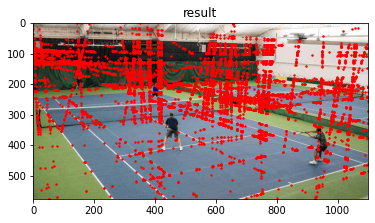

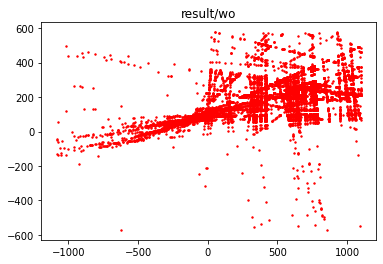

In [28]:
plt.figure(1)
plt.title('result')
plt.scatter([i[1] for i in intersect_points],[i[0] for i in intersect_points],c='r',s=2)
# plt.gca().invert_yaxis()
plt.imshow(im)
plt.figure(2)
plt.title('result/wo')
plt.scatter([i[1] for i in intersect_points],[i[0] for i in intersect_points],c='r',s=2)

In [29]:
def add_court_overlay(frame, homography, overlay_color=(255, 255, 255)):
    court_reference = cv2.imread("pictures/court_reference.png", 0)
    court = cv2.warpPerspective(court_reference, homography, (frame.shape[1],frame.shape[0]))
    # court = cv2.warpPerspective(court_reference, homography, frame.shape[1::-1])
    frame[court == 255, :] = overlay_color
    return frame

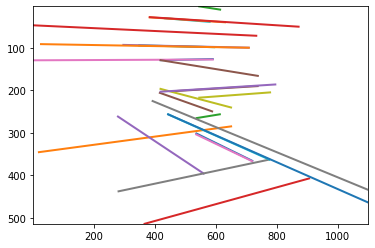

In [30]:
plt.figure(1)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
            ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
        plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
plt.gca().invert_yaxis()
 

In [31]:
im.shape

(577, 1100, 3)

In [32]:
# t = 0.94
# plt.gca().set_axis_off()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.margins(0, 0)

# new_nlines = np.zeros((2,2,2))
# new_nscores = np.zeros((2))
# bottom_1 = -1
# bottom_2 = -1
# for (a, b), s in zip(nlines, nscores):
#     if s < t:
#         continue
    
#     # is horizontal
#     # has a point in the middle of the image
#     if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
#             ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
#         min_bottom = min(bottom_1, bottom_2)
#         if a[0] > min_bottom and b[0] > min_bottom:
#             if(bottom_1 == min_bottom):
#                 bottom_1 = (a[0]+b[0])/2
#                 new_nlines[0][0] = a
#                 new_nlines[0][1] = b
#                 new_nscores[0] = s
#             else:
#                 bottom_2 = (a[0]+b[0])/2
#                 new_nlines[1][0] = a
#                 new_nlines[1][1] = b
#                 new_nscores[1] = s

# court_points = new_nlines.copy()
# if(court_points[0][0][0] > court_points[1][0][0]):
#     court_points = np.flip(court_points, 0)
# for i, p in enumerate(court_points):
#     court_points[i] = np.flip(court_points[i], 1)
# for i, p in enumerate(court_points):
#     court_points[i] = p[p[:, 0].argsort()]
# # print(court_points)
# court_points = court_points.reshape(-1, new_nlines.shape[-1])

# court_points_new = court_points

# print("----------------------------")
# print(court_points)
# print(court_points_new)
# print("----------------------------")

# template_points = np.asarray([[147, 1839], [970, 1839], [10, 2388], [1107, 2388]])
# # T, _, _ = best_fit_transform(template_points, court_points)
# T, status = cv2.findHomography(template_points, np.asarray(court_points_new))
# plt.imshow(im)
# plt.show()
# plt.imshow(T)
# plt.show()
# court = add_court_overlay(im, T, overlay_color=(255, 0, 0))
# for c in court_points_new:
#     cv2.circle(court, (int(c[0]), int(c[1])), 3, (255,0,0), cv2.FILLED)
# # court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
# plt.imshow(court)
# plt.show()

In [33]:
def GetVanishingPoint(Lines):
    # We will apply RANSAC inspired algorithm for this. We will take combination 
    # of 2 lines one by one, find their intersection point, and calculate the 
    # total error(loss) of that point. Error of the point means root of sum of 
    # squares of distance of that point from each line.
    VanishingPoint = None
    MinError = 100000000000

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)

                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

In [34]:
def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line

        # Calculating equation of the line: y = mx + c
        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2
        # theta will contain values between -90 -> +90. 
        theta = math.degrees(math.atan(m))

        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, m, c, l])

    
    # Removing extra lines 
    # (we might get many lines, so we are going to take only longest 15 lines 
    # for further computation because more than this number of lines will only 
    # contribute towards slowing down of our algo.)
    if len(FinalLines) > 15:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:15]
    
    return FinalLines

In [35]:
def FilterLines2(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line[0]
        theta = Line[1]
        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if  filter_th[0]-REJECT_DEGREE_TH<= theta <=filter_th[0]+REJECT_DEGREE_TH \
        or filter_th[1]-REJECT_DEGREE_TH<= theta <=filter_th[1]+REJECT_DEGREE_TH:
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, theta, l])

    
    return FinalLines

In [36]:
print(line_w_thetas[0][0])
[[x1, y1], [x2, y2]] = line_w_thetas[0][0]
print(x1,y1,x2,y2)

[[365.82223213 720.00941038]
 [301.60399413 536.71755791]]
365.82223212718964 720.0094103813171 301.60399413108826 536.7175579071045


In [37]:
LineSS = FilterLines2(line_w_thetas)
print(LineSS[0])

[365.82223212718964, 720.0094103813171, 301.60399413108826, 536.7175579071045, 70.69155124782836, 194.21607882652881]


In [38]:
# Drawing lines and vanishing point
im3 = np.copy(im)
lines32 = np.float32(LineSS)
print(lines32[0])
for Line in lines32:
    cv2.line(im3, (Line[1], Line[0]), (Line[3], Line[2]), (0, 255, 0), 2)
# cv2.circle(im3, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

# Showing the final image
cv2.imshow("OutputImage", im3)
cv2.waitKey(0)
cv2.destroyAllWindows()

[365.82224 720.0094  301.604   536.7175   70.69155 194.21608]


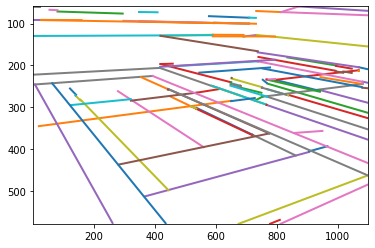

In [39]:
# Drawing lines and vanishing point
plt.figure(2)
plt.margins(0, 0)
lines32 = np.float32(LineSS)
for Line in lines32:
    # cv2.line(im, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
    plt.plot((Line[1], Line[3]), (Line[0], Line[2]), linewidth=2)
# plt.scatter(VanishingPoint[0], VanishingPoint[1],**PLTOPTS)    
    # Showing the final imageplt.gca().invert_yaxis()
plt.gca().invert_yaxis()

In [40]:
GrayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#Blurring image to reduce noise.
BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
# Generating Edge image
EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

# Finding Lines in the image
Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)

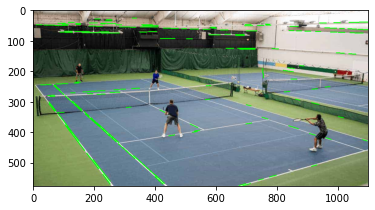

In [41]:
im4 = np.copy(im)
for Line in Lines:
    Line = Line[0]
    cv2.line(im4,(Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
# cv2.circle(im, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)
cv2.imshow("OutputImage", im4)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(im4)
plt.show()
plt.close()

In [42]:
def calculate_metric_angle(current_hypothesis, lines, ignore_pts, ransac_angle_thresh):
    current_hypothesis = current_hypothesis / current_hypothesis[-1]
    hypothesis_vp_direction = current_hypothesis[:2] - lines[:,0]
    lines_vp_direction = lines[:,1] - lines[:,0]
    magnitude = np.linalg.norm(hypothesis_vp_direction, axis=1) * np.linalg.norm(lines_vp_direction, axis=1)
    magnitude[magnitude == 0] = 1e-5
    cos_theta = (hypothesis_vp_direction*lines_vp_direction).sum(axis=-1) / magnitude
    cos_theta = np.clip(cos_theta, -1, 1)
    theta = np.arccos(np.abs(cos_theta))

    inliers = (theta < ransac_angle_thresh * np.pi / 180)
    inliers[ignore_pts] = False
    # theta = np.rad2deg(np.average(theta[inliers]))
    # print(theta)
    return inliers, inliers.sum()

In [43]:
def run_line_ransac(lines, ransac_iter, ransac_angle_thresh, ignore_pts=None):
    best_vote_count = 0
    best_inliers = None
    best_hypothesis = None
    if ignore_pts is None:
        ignore_pts = np.zeros((lines.shape[0])).astype('bool')
        lines_to_chose = np.arange(lines.shape[0])
    else:
        lines_to_chose = np.where(ignore_pts==0)[0]
    for iter_count in range(ransac_iter):
        idx1, idx2 = np.random.choice(lines_to_chose, 2, replace=False)
        l1 = np.cross(np.append(lines[idx1][1], 1), np.append(lines[idx1][0], 1))
        l2 = np.cross(np.append(lines[idx2][1], 1), np.append(lines[idx2][0], 1))

        current_hypothesis = np.cross(l1, l2)
        if current_hypothesis[-1] == 0:
            continue
        inliers, vote_count = calculate_metric_angle(current_hypothesis, lines, ignore_pts, ransac_angle_thresh)
        if vote_count > best_vote_count:
            best_vote_count = vote_count
            best_hypothesis = current_hypothesis
            best_inliers = inliers
    return best_hypothesis, best_inliers

In [44]:
def get_vp_inliers(nlines, iterations, threshold):

    best_hypothesis_1, best_inliers_1 = run_line_ransac(nlines, iterations, threshold)
    ignore_pts = best_inliers_1
    best_hypothesis_2, best_inliers_2 = run_line_ransac(nlines, iterations, threshold, ignore_pts=ignore_pts)
    ignore_pts = np.logical_or(best_inliers_1, best_inliers_2)
    best_hypothesis_3, best_inliers_3 = run_line_ransac(nlines, iterations, threshold, ignore_pts=ignore_pts)
    inlier_lines_list = [best_inliers_1, best_inliers_2, best_inliers_3]
    best_hypothesis_1 = best_hypothesis_1 / best_hypothesis_1[-1]
    best_hypothesis_2 = best_hypothesis_2 / best_hypothesis_2[-1]
    best_hypothesis_3 = best_hypothesis_3 / best_hypothesis_3[-1]
    hypothesis_list = [best_hypothesis_1, best_hypothesis_2, best_hypothesis_3]
    return inlier_lines_list, hypothesis_list

In [45]:
def visualize_inliers(image, lines, inlier_lines_list, colors, fig_name='detected_lines.png'):
    subplot_count = len(inlier_lines_list)

    fig, axes = plt.subplots(1, subplot_count, figsize=(15, 15), sharex=True, sharey=True)
    ax = axes.ravel()
    for i in range(len(inlier_lines_list)):
        ax[i].imshow(im)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            ax[i].plot((p0[1], p1[1]),(p0[0], p1[0]), colors[i])
        ax[i].set_xlim((0, image.shape[1]))
        ax[i].set_ylim((image.shape[0], 0))
        ax[i].set_title('RANSAC {} Inliers'.format(str(i)))

    for a in ax:
        a.set_axis_off()

    plt.tight_layout() 
    plt.show()
    # plt.savefig(fig_name)
    plt.close()

    plt.figure(8)
    for i in range(len(inlier_lines_list)):
        plt.imshow(im)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[1], p1[1]),(p0[0], p1[0]), colors[i])


    plt.tight_layout() 
    plt.show()
    # plt.savefig(fig_name)
    plt.close()

In [46]:
def visualize_vanishing_points(vp1, vp2, vp3, image, lines, inlier_lines_list, colors):
    vps = [vp1, vp2, vp3]
    for i in range(len(inlier_lines_list)):
        plt.imshow(image)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[0], p1[0]), (p0[1], p1[1]), colors[i])

        plt.plot([vps[i][0]], [vps[i][1]], colors[i]+'X', markersize=5)
        plt.axis('off')
        plt.tight_layout()
        plt.close()

    plt.imshow(image)
    for i in range(len(inlier_lines_list)):
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[1], p1[1]), (p0[0], p1[0]), colors[i])

    plt.plot([vps[0][1]], [vps[0][0]], colors[0]+'X', markersize=5)
    plt.plot([vps[1][1]], [vps[1][0]], colors[1]+'X', markersize=5)
    plt.plot([vps[2][1]], [vps[2][0]], colors[2]+'X', markersize=5)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close() 

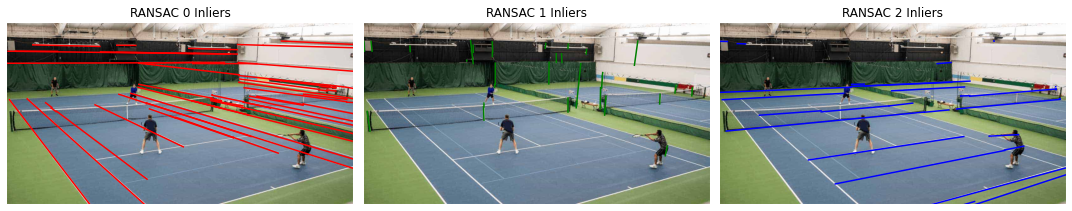

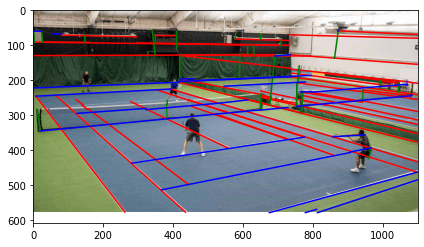

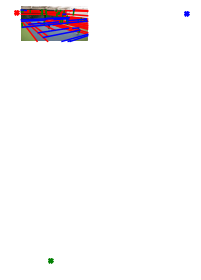

In [47]:
ransac_iters = 1000
angle_threshold = 5 # degrees
inlier_lines_list, hypothesis_list = get_vp_inliers(nlines2,ransac_iters, angle_threshold)
best_hypothesis_1, best_hypothesis_2, best_hypothesis_3 = hypothesis_list
colors = ['r', 'g', 'b']
visualize_inliers(im, nlines2, inlier_lines_list, colors)
visualize_vanishing_points(best_hypothesis_1, best_hypothesis_2, best_hypothesis_3,
                               im, nlines2, inlier_lines_list, colors)

In [48]:
inlier_1 = 0
inlier_2 = 2
# court_reference = CourtReference()

In [49]:
def sort_intersection_points(intersections):
    """
    sort intersection points from top left to bottom right
    """
    y_sorted = sorted(intersections, key=lambda x: x[1])
    p12 = y_sorted[:2]
    p34 = y_sorted[2:]
    p12 = sorted(p12, key=lambda x: x[0])
    p34 = sorted(p34, key=lambda x: x[0])
    return p12 + p34


In [51]:
def rotateHToLine(H, line):
    assert len(line) == 3
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Compute transformed line = H^-T * l
    lineTr = np.dot(np.linalg.inv(H).T, line)

    # Rotate so that this line is horizonal in the image 
    r1 = np.array([lineTr[1], -lineTr[0]]) # First row of R is perpendicular to linesTr[0]
    r1 = r1 / np.linalg.norm(r1.flatten())
    theta = np.arctan2(-r1[1] , r1[0])
    if abs(theta) < pi/4:
        R = np.array([[r1[0],  r1[1]], [-r1[1], r1[0]]])
    else:
        R = np.identity(2)
        #R = np.array([[r1[1], -r1[0]], [ r1[0], r1[1]]])
    theta = np.arctan2(R[1,0], R[1,1])
    print("Rotating by %.1f degrees" % (theta*180/pi))
    HR = np.identity(3)
    HR[0:2,0:2] = R

    return np.dot(HR,H)

In [52]:
def translateHToPosQuadrant(H, limits):
    assert len(limits) >= 2 # can have color channels
    assert limits[0] > 0 and limits[1] > 0
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Get H * image corners
    Hcor, finite = getHCorners(H, limits)
    print(Hcor)
    # Check if corners map to infinity, if so skip translation
    if not finite:
        print("Corners map to infinity, skipping translation")
        return H

    # Min coordinates of H * image corners
    minc = [min([Hcor[j][i]/Hcor[j][2] for j in range(len(Hcor))]) for i in range(2)]

    # Choose translation
    HT = np.identity(3)
    HT[0,2] = -minc[0]
    HT[1,2] = -minc[1]

    return np.dot(HT, H)

In [53]:
def scaleHToImage(H, limits, anisotropic = False): # TODO: test anisotropic
    assert len(limits) >= 2 # can have color channels
    assert limits[0] > 0 and limits[1] > 0
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Get H * image corners
    Hcor, finite = getHCorners(H, limits)

    # If corners in the transformed image are not finite, don't do scaling
    if not finite:
        print("Skipping scaling due to point mapped to infinity")
        return H;
        
    # Maximum coordinate that any corner maps to
    k = [max([Hcor[j][i] / Hcor[j][2] for j in range(len(Hcor))])/float(limits[i]) for i in range(2)]
    # Scale
    if anisotropic:
        print("Scaling by (%f,%f)\n" % (k[0], k[1]))
        HS = np.array([[1./k[0],0.0,0.0],[0.0,1./k[1],0.0],[0.0,0.0,1.0]])
    else:
        k = max(k)
        # if k>15:
        #     k=15
        print("Scaling by %f\n" % k)
        HS = np.array([[1.0/k,0.0,0.0],[0.0,1.0/k,0.0],[0.0,0.0,1.0]])

    return np.dot(HS, H)

In [54]:
def getHCorners(H, limits):
    Ny = float(limits[0])
    Nx = float(limits[1])
    # Apply H to corners of the image to determine bounds
    Htr  = np.dot(H, np.array([0.0, Ny, 1.0]).flatten()) # Top left maps to here
    Hbr  = np.dot(H, np.array([Nx,  Ny, 1.0]).flatten()) # Bottom right maps to here
    Hbl  = np.dot(H, np.array([Nx, 0.0, 1.0]).flatten()) # Bottom left maps to here
    Hcor = [Htr,Hbr,Hbl]
    

    # Check if corners in the transformed image map to infinity finite
    finite = True 
    for y in Hcor:
        if y[2] == 0:
            finite = False

    return Hcor, finite

In [55]:
vLine = np.cross(best_hypothesis_1, best_hypothesis_2)
print(best_hypothesis_1,best_hypothesis_2)
print("Vanishing line:")
print(vLine)
H = np.identity(3)
H[2,0] = vLine[0] / vLine[2]
H[2,1] = vLine[1] / vLine[2]

print("H:")
print(H)



[ 90.57771556 -92.83523167   1.        ] [4.20495765e+03 4.68621947e+02 1.00000000e+00]
Vanishing line:
[  -561.4571786    4114.37993289 432814.92286654]
H:
[[ 1.          0.          0.        ]
 [ 0.          1.          0.        ]
 [-0.00129722  0.0095061   1.        ]]


In [56]:

# H = rotateHToLine(H, [inlier_lines_list[0],1])
H = translateHToPosQuadrant(H, im.shape)
H = scaleHToImage(H, im.shape, False)


[array([  0.        , 577.        ,   6.48501703]), array([1100.        ,  577.        ,    5.05807247]), array([ 1.10000000e+03,  0.00000000e+00, -4.26944553e-01])]
Scaling by 4.842151



In [57]:
result = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
cv2.imshow('output',result) 
cv2.imwrite('output.png',result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [58]:
# im_cv = cv2.imread(img)
# padding = 100
# im_cv= cv2.copyMakeBorder(im_cv,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=[255,255,255])
# list1 = []      # separate lists to store the coordinates for the separate lines
# list2 = []
# check = 0       # variable to switch between the lists

# def getPoints(event, x, y, flags, params):
    
#     global list1, list2, check    
   
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print (x,y)
#         if check < 4:
#             list1.append([x, y])
#             check += 1
#         else:
#             list2.append([x, y])
#     elif event == cv2.EVENT_LBUTTONUP:                   
#         cv2.circle(im_cv,(x,y), 4, (0,255,0), -1)
#         cv2.imshow("image", im_cv)

    
# cv2.namedWindow("image")
# cv2.setMouseCallback("image", getPoints)

# def selectPoints():
#     global check
#     while True:
#         cv2.imshow("image", im_cv)
#         key = cv2.waitKey(1) & 0xFF        
        
#         if key == ord("q"):
#             break
# #         elif check == 7:
# #             break
        
# selectPoints()
# cv2.destroyAllWindows()
# cv2.waitKey(1)

In [59]:
# width_AD = np.sqrt(((list1[0][0] - list1[3][0]) ** 2) + ((list1[0][1] - list1[3][1]) ** 2))
# width_BC = np.sqrt(((list1[1][0] - list1[2][0]) ** 2) + ((list1[1][1] - list1[2][1]) ** 2))
# maxWidth = max(int(width_AD), int(width_BC))


# height_AB = np.sqrt(((list1[0][0] - list1[1][0]) ** 2) + ((list1[0][1] - list1[1][1]) ** 2))
# height_CD = np.sqrt(((list1[2][0] - list1[3][0]) ** 2) + ((list1[2][1] - list1[3][1]) ** 2))
# maxHeight = max(int(height_AB), int(height_CD))
# output_pts = np.float32([[0, 0],
#                         [0, maxHeight - 1],
#                         [maxWidth - 1, maxHeight - 1],
#                         [maxWidth - 1, 0]])

In [60]:
# width , height = 350 , 550
# list11 = np.float32(list1) 
# # list22 = np.float32([[0,0],[width,0],[0,height],[width,height]])
# matrix = cv2.getPerspectiveTransform(list11,output_pts)
# output = cv2.warpPerspective(im_cv,matrix,(maxWidth,maxHeight))
# # cv2.imshow('output',output) 
# cv2.imwrite('output.png',output)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# plt.imshow(output)
# plt.show()
# plt.close()

In [61]:
# print(matrix)

In [62]:
def intersect(a1, a2, b1, b2):
    x1,y1 = a1
    x2,y2 = a2
    x3,y3 = b1
    x4,y4 = b2
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return [x,y]

(2408, 1127)


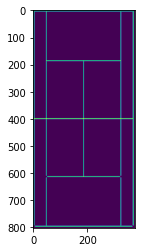

In [63]:
template_points = np.asarray([[147, 1839], [970, 1839], [10, 2388], [1107, 2388]])
court_reference = cv2.imread("pictures/court_reference.png", 0)
print(court_reference.shape)
for c in template_points:
    cv2.circle(court_reference, (int(c[0]), int(c[1])), 10, (0,255,0), cv2.FILLED)
imS = cv2.resize(court_reference, (int(court_reference.shape[1]/3), int(court_reference.shape[0]/3)))
# cv2.imshow("Court", imS)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(imS)
plt.show()
plt.close()

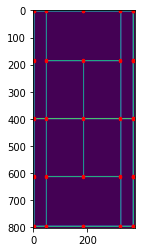

In [64]:
dst = cv2.Canny(imS, 50, 200, None, 3)
    
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
# cdstP = np.copy(cdst)

lines11 = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
template_lines = []
if lines11 is not None:
    for i in range(0, len(lines11)):
        rho = lines11[i][0][0]
        theta = lines11[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        template_lines.append([pt1,pt2])
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


# linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

# if linesP is not None:
#     for i in range(0, len(linesP)):
#         l = linesP[i][0]
#         cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
 
# cv2.imshow("Source", imS)
cv2.imshow("Detected Lines (in red) - Standard Hough Line Transform", cdst)
# cv2.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)

cv2.waitKey()
cv2.destroyAllWindows()

temp_intersect = []
for i in range(len(template_lines)-1):
    for j in range(i+1,len(template_lines)):
        ptt2 = intersect(template_lines[i][0],template_lines[i][1],template_lines[j][0],template_lines[j][1])
        # print(ptt2)
        if ptt2 is not None:
            temp_intersect.append(ptt2)
            plt.scatter(ptt2[0],ptt2[1], c = 'r',s=6)
plt.imshow(imS)

In [65]:
temp_intersect

[[369.0, 0.6848424212105328],
 [369.0, 795.6848424212105],
 [369.0, 3.684842421210533],
 [369.0, 397.68484242121065],
 [369.0, 399.68484242121065],
 [369.0, 793.6848424212105],
 [369.0, 183.68484242121065],
 [369.0, 186.68484242121065],
 [369.0, 612.6848424212106],
 [369.0, 610.6848424212106],
 [1.0, 0.5007503751876357],
 [1.0, 795.5007503751876],
 [1.0, 3.5007503751876357],
 [1.0, 397.50075037518764],
 [1.0, 399.50075037518764],
 [1.0, 793.5007503751876],
 [1.0, 183.50075037518764],
 [1.0, 186.50075037518752],
 [1.0, 612.5007503751876],
 [1.0, 610.5007503751876],
 [4.0, 0.5022511255627933],
 [4.0, 795.5022511255628],
 [4.0, 3.5022511255627933],
 [4.0, 397.5022511255628],
 [4.0, 399.5022511255628],
 [4.0, 793.5022511255628],
 [4.0, 183.50225112556268],
 [4.0, 186.50225112556268],
 [4.0, 612.5022511255628],
 [4.0, 610.5022511255628],
 [367.0, 0.6838419209605036],
 [367.0, 795.6838419209605],
 [367.0, 3.6838419209605036],
 [367.0, 397.6838419209605],
 [367.0, 399.6838419209605],
 [367.0,

In [66]:
court_reference.shape

(2408, 1127)

In [67]:
# im5 = np.copy(im)
# padding = 100
# im5= cv2.copyMakeBorder(im5,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=[255,255,255])
# # list1 = np.asarray([[219, 702],[1769, 707],[1186, 194],[794, 198]]) 
# factor_s = 2.11
# template_try= np.asarray([[0, 0], [2408/factor_s, 0], [2408/factor_s, 1127*factor_s], [0, 1127*factor_s]])
# T, status = cv2.findHomography(template_try, np.asarray(list1))
# court = add_court_overlay(im5, T, overlay_color=(255, 0, 0))
# # for c in court_points_new:
# #     cv2.circle(court, (int(c[0]), int(c[1])), 3, (255,0,0), cv2.FILLED)
# court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
# cv2.imshow("Court", court)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# plt.imshow(court)
# plt.show()
# plt.close()

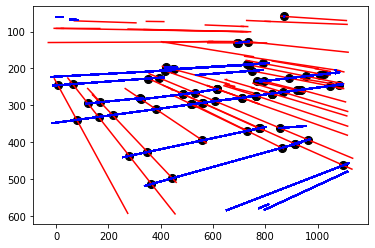

In [68]:
s_factor = 1.1
section = []
section_ind = []
inter_pts = []
for i,line1 in enumerate(nlines2[inlier_lines_list[inlier_1]]):
    a0,a1 = line1
    a0 = [a0[0] *(1+s_factor)/2 + a1[0] *(1-s_factor)/2 , a0[1] *(1+s_factor)/2 + a1[1] *(1-s_factor)/2]
    a1 = [a1[0] *(1+s_factor)/2 + a0[0] *(1-s_factor)/2 , a1[1] *(1+s_factor)/2 + a0[1] *(1-s_factor)/2]
    plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), 'r')
    counter = 0
    for j,line2 in enumerate(nlines2[inlier_lines_list[inlier_2]]):
        b0,b1 = line2
        b0 = [b0[0] *(1+s_factor)/2 + b1[0] *(1-s_factor)/2 , b0[1] *(1+s_factor)/2 + b1[1] *(1-s_factor)/2]
        b1 = [b1[0] *(1+s_factor)/2 + b0[0] *(1-s_factor)/2 , b1[1] *(1+s_factor)/2 + b0[1] *(1-s_factor)/2]
        plt.plot((b0[1], b1[1]),(b0[0], b1[0] ), 'b')
        intersect_pt = intersect(a0,a1,b0,b1)
        # print (intersect_pt)
        if intersect_pt is not None:
            plt.scatter(intersect_pt[1],intersect_pt[0],c='k',s=65)
            if(counter==0):
                section.append([line1,line2])
                section_ind.append([i,j+len(inlier_lines_list[inlier_1])])
                inter_pts.append([intersect_pt])
            else:
                section[-1].append(line2)
                section_ind[-1].append(j+len(inlier_lines_list[inlier_1]))
                inter_pts[-1].append(intersect_pt)
            counter +=1
            
plt.gca().invert_yaxis()
  
# for i in range(len(inlier_lines_list)-1):
#     plt.imshow(im)
#     for line in nlines2[inlier_lines_list[i]]:
#         p0, p1 = line
#         plt.plot((p0[1], p1[1]),(p0[0], p1[0] ), colors[i])

In [69]:
for i , n in enumerate(inter_pts):
    print(i,':', len(n))

0 : 4
1 : 2
2 : 4
3 : 1
4 : 1
5 : 1
6 : 1
7 : 1
8 : 1
9 : 1
10 : 1
11 : 1
12 : 2
13 : 1
14 : 2
15 : 1
16 : 1
17 : 1
18 : 1
19 : 5
20 : 2
21 : 2
22 : 3
23 : 1
24 : 3
25 : 6
26 : 1
27 : 3
28 : 3
29 : 1
30 : 2
31 : 1
32 : 1
33 : 1
34 : 5
35 : 1


In [70]:

merge_sec = section[0]
print(section_ind[0])
for current_sec in section_ind[1:]:
    print(current_sec)
    # for line in current_sec:
        # print(line)
    

[3, 176, 181, 193, 195]
[4, 178, 181]
[5, 176, 178, 181, 195]
[7, 177]
[15, 186]
[16, 186]
[19, 186]
[22, 186]
[23, 206]
[29, 185]
[34, 182]
[35, 180]
[37, 186, 188]
[38, 186]
[40, 176, 185]
[41, 188]
[42, 180]
[44, 176]
[45, 179]
[47, 176, 185, 191, 193, 205]
[49, 177, 202]
[50, 177, 202]
[53, 179, 199, 206]
[54, 208]
[55, 176, 181, 193]
[57, 176, 178, 181, 187, 191, 193]
[58, 176]
[59, 183, 186, 188]
[64, 179, 188, 206]
[65, 186]
[67, 186, 200]
[69, 188]
[70, 186]
[84, 186]
[85, 176, 178, 181, 185, 195]
[86, 180]


In [71]:
merged_ind = section_ind
out = []
while len(merged_ind)>0:
    first, *rest = merged_ind
    first = set(first)

    lf = -1
    while len(first)>lf:
        lf = len(first)

        rest2 = []
        for r in rest:
            if len(first.intersection(set(r)))>0:
                first |= set(r)
            else:
                rest2.append(r)     
        rest = rest2

    out.append(first)
    merged_ind = rest

print(out)

[{193, 3, 195, 4, 5, 205, 85, 29, 57, 40, 44, 47, 176, 178, 181, 55, 185, 58, 187, 191}, {177, 49, 50, 7, 202}, {64, 65, 67, 69, 70, 199, 200, 206, 15, 16, 19, 84, 22, 23, 37, 38, 41, 45, 179, 53, 183, 186, 59, 188}, {34, 182}, {35, 180, 86, 42}, {208, 54}]


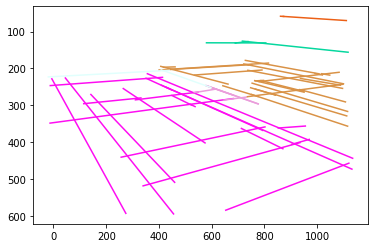

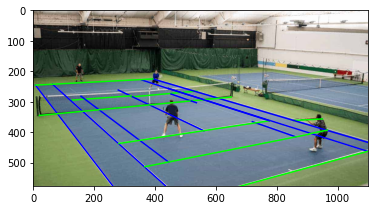

In [72]:
plt.figure(11)
target_lines = [[],[]]
for sec in out:
    # sec = out[0]
    r = np.random.rand(3,)
    for line1 in sec:
        if line1< len(inlier_lines_list[inlier_1]):      
            a0,a1 = nlines2[inlier_lines_list[inlier_1]][line1]
        else:
            line1-= len(inlier_lines_list[inlier_1])
            a0,a1 = nlines2[inlier_lines_list[inlier_2]][line1]
        a0 = [a0[0] *(1+s_factor)/2 + a1[0] *(1-s_factor)/2 , a0[1] *(1+s_factor)/2 + a1[1] *(1-s_factor)/2]
        a1 = [a1[0] *(1+s_factor)/2 + a0[0] *(1-s_factor)/2 , a1[1] *(1+s_factor)/2 + a0[1] *(1-s_factor)/2]
        plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), c=r)
plt.gca().invert_yaxis()

plt.figure(12)

sec = out[0]
r = np.random.rand(3,)
for line1 in sec:
    if line1< len(inlier_lines_list[inlier_1]):      
        a0,a1 = nlines2[inlier_lines_list[inlier_1]][line1]
        cc = [0.0,0.0,1.0]
        target_lines[0].append([a0,a1])
    else:
        line1-= len(inlier_lines_list[inlier_1])
        a0,a1 = nlines2[inlier_lines_list[inlier_2]][line1]
        target_lines[1].append([a0,a1])
        cc = [0,1,0]
    plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), c=cc)
plt.gca().invert_yaxis()
plt.imshow(im)

In [73]:
def midpoint(line):
    return ((line[0][0]+line[1][0])/2, (line[0][1]+line[1][1])/2)

In [74]:
def find_line_eq (line):
    x_f = 0
    x_e = im.shape[1]
    y_f = 0
    y_e = im.shape[0]
    y_coords, x_coords = zip(*line)
    # print(x_coords)
    print('y coords: ', y_coords, 'x coords: ',x_coords)
    plt.plot(x_coords,y_coords, c='r')
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords,rcond=None)[0]
    print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    theta = math.degrees(math.atan(m))
    print(theta)
    x0 = (y_f-c)/m
    x1 = (y_e-c)/m

    if x0 > x_e or x0< x_f:
        x0 = np.clip(x0,0,x_e)
        y0 = (m * x0) + c
    else:
        y0 = y_f

    if x1 > x_e or x1< x_f:
        x1 = np.clip(x1,0,x_e)
        y1 = (m * x1) + c
    else:
        y1 = y_e

    print("new line before clipping:", [x0,y0],[x1,y1])
    # x0 = np.clip(x0,0,x_e)
    # x1 = np.clip(x1,0,x_e)
    # y0 = np.clip(y0,0,y_e)
    # y1 = np.clip(y1,0,y_e)
    # print("New Line Solution is",[x0,y0],[x1,y1])
    plt.plot((x0,x1),(y0,y1), c=[1,0,0])
    plt.imshow(im)
    plt.show()
    
    # plt.gca().invert_yaxis()
    return [[y0,x0],[y1,x1]] , theta

------------------
y coords:  (395.7313369512558, 261.7957025170326) x coords:  (560.6302678585052, 279.43495512008667)
Line Solution is y = 0.47630820417983466x + 128.69854085871137
25.468843303684153
new line before clipping: [0.0, 128.69854085871137] [941.2003723791165, 577]


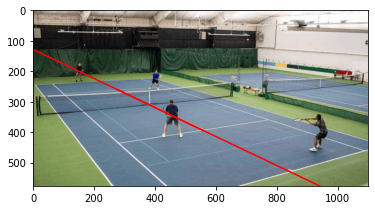

y coords:  (415.6792808175087, 365.7773730563374) x coords:  (862.5670373439789, 720.0251149065379)
Line Solution is y = 0.3500858337523291x + 113.70678038166552
19.29442731506631
new line before clipping: [0.0, 113.70678038166552] [1100.0, 498.8011975092275]


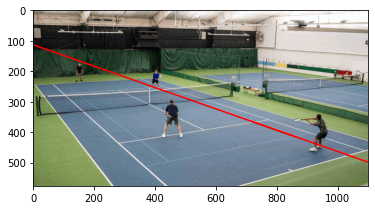

y coords:  (498.6681942343712, 282.2389066517353) x coords:  (445.1058238744736, 156.98985159397125)
Line Solution is y = 0.7511880923141815x + 164.30999952017365
36.91343931850013
new line before clipping: [0.0, 164.30999952017365] [549.3830436108942, 577]


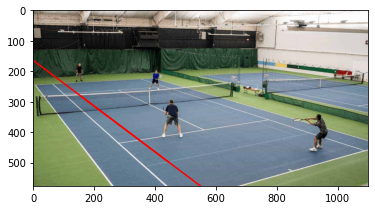

y coords:  (242.84632688760757, 577.6564722061157) x coords:  (63.691455125808716, 435.7544034719467)
Line Solution is y = 0.8998749991279086x + 185.53197876181517
41.98325533140837
new line before clipping: [0.0, 185.53197876181517] [435.0248885873775, 577]


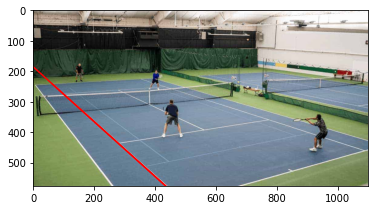

y coords:  (228.31077075004578, 257.12819132208824) x coords:  (355.4975628852844, 443.90054047107697)
Line Solution is y = 0.32597794055156154x + 112.42640732960159
18.05482593508193
new line before clipping: [0.0, 112.42640732960159] [1100.0, 471.0021419363193]


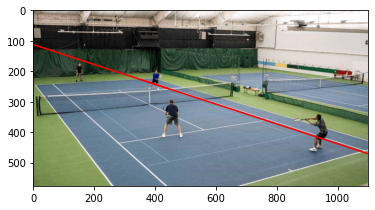

y coords:  (463.29047095775604, 256.6197664456529) x coords:  (1098.8412022590637, 444.0610165051577)
Line Solution is y = 0.31563371801506945x + 116.45913678057876
17.517453110477376
new line before clipping: [0.0, 116.45913678057876] [1100.0, 463.6562265971552]


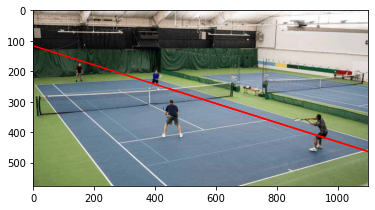

y coords:  (577.1081968545914, 245.72836643457413) x coords:  (261.64304316043854, 7.240111194550991)
Line Solution is y = 1.3025786607854488x + 236.29755209083814
52.486263898080516
new line before clipping: [0.0, 236.29755209083814] [261.55997957445413, 577]


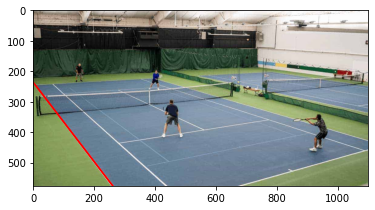

y coords:  (298.16900193691254, 274.8715296983719) x coords:  (519.470688700676, 452.69767343997955)
Line Solution is y = 0.3489054994383923x + 116.92282185219763
19.234160560946265
new line before clipping: [0.0, 116.92282185219763] [1100.0, 500.7188712344291]


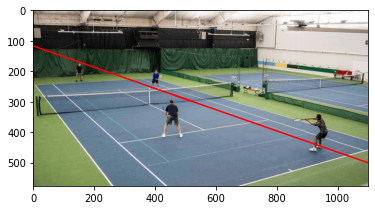

y coords:  (433.7075043320656, 225.37599125504494) x coords:  (1099.0569114685059, 393.1003659963608)
Line Solution is y = 0.29510529283029496x + 109.36999263599287
16.441608924402132
new line before clipping: [0.0, 109.36999263599287] [1100.0, 433.98581474931734]


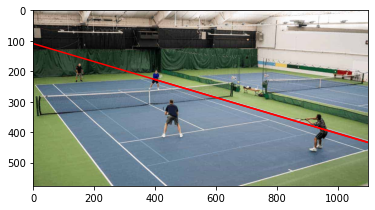

y coords:  (256.6575948793593, 362.8783215880394) x coords:  (444.0511826992089, 775.8777678012848)
Line Solution is y = 0.3201091518209871x + 114.51274742040948
17.750344466588118
new line before clipping: [0.0, 114.51274742040948] [1100.0, 466.6328144234953]


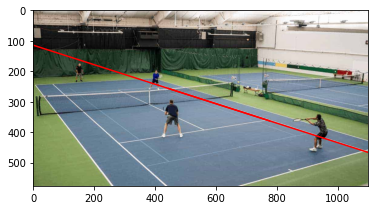

y coords:  (303.51500626054633, 297.84873070370514) x coords:  (536.0743584962186, 519.5807156411297)
Line Solution is y = 0.34354300057448195x + 119.35041261171479
18.95980028809184
new line before clipping: [0.0, 119.35041261171479] [1100.0, 497.2477132436449]


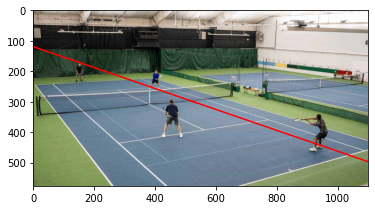

------------------
y coords:  (265.37584564089775, 284.4526087939739) x coords:  (537.6890361309052, 321.99326753616333)
Line Solution is y = -0.08844291789941627x + 312.9306329188395
-5.054254920683049
new line before clipping: [1100.0, 215.64342322948158] [0.0, 312.9306329188395]


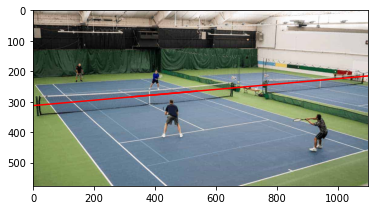

y coords:  (280.9416278501365, 295.11596596241) x coords:  (321.74019294726133, 125.09527802467346)
Line Solution is y = -0.0720808779512728x + 304.13294342998705
-4.122799743949979
new line before clipping: [1100.0, 224.84397768358696] [0.0, 304.13294342998705]


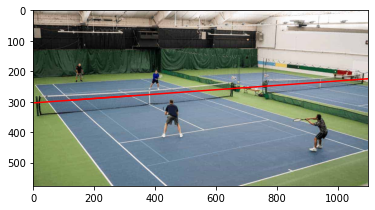

y coords:  (361.76306170225143, 356.8657267689705) x coords:  (857.0259988307953, 950.0371217727661)
Line Solution is y = -0.05265321800637097x + 406.88823845581703
-3.0140239045966015
new line before clipping: [1100.0, 348.96969864880896] [0.0, 406.88823845581703]


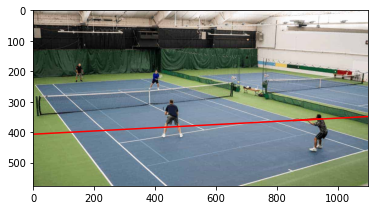

y coords:  (284.9166584312916, 345.4629957675934) x coords:  (650.5090832710266, 20.178543403744698)
Line Solution is y = -0.09605490057494269x + 347.40124374798717
-5.486707274565073
new line before clipping: [1100.0, 241.7408531155502] [0.0, 347.40124374798717]


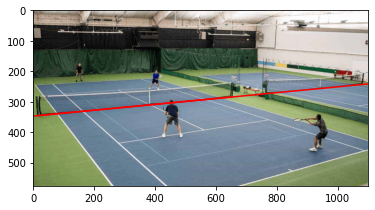

y coords:  (513.7299461364746, 407.18211340904236) x coords:  (366.83399975299835, 906.3597440719604)
Line Solution is y = -0.19748424213181273x + 586.173880565877
-11.17126728526193
new line before clipping: [1100.0, 368.94121422088296] [46.45373457064882, 577]


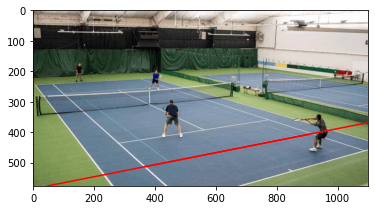

y coords:  (437.4408460855484, 362.8783215880394) x coords:  (281.4049571752548, 775.8777678012848)
Line Solution is y = -0.1507919604378417x + 479.87445125493207
-8.575137942846156
new line before clipping: [1100.0, 314.00329477330615] [0.0, 479.87445125493207]


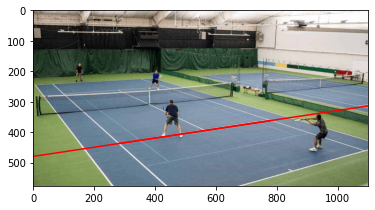

y coords:  (245.72836643457413, 225.37599125504494) x coords:  (7.240111194550991, 393.1003659963608)
Line Solution is y = -0.05274545622736626x + 246.11024940266768
-3.0192941287929904
new line before clipping: [1100.0, 188.0902475525648] [0.0, 246.11024940266768]


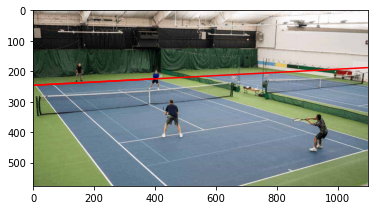

y coords:  (463.29047095775604, 579.0948781967163) x coords:  (1098.8412022590637, 675.476211309433)
Line Solution is y = -0.27353326258556343x + 763.8600900751212
-15.298092655579655
new line before clipping: [1100.0, 462.9735012310014] [683.1347979724032, 577]


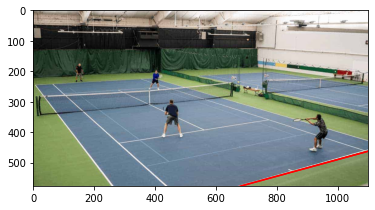

y coords:  (405.6804047375499, 393.53985196352005) x coords:  (906.0588326090924, 966.6466653347015)
Line Solution is y = -0.20037938688139245x + 587.23591809423
-11.330832166643757
new line before clipping: [1100.0, 366.81859252469826] [51.08268995896659, 577]


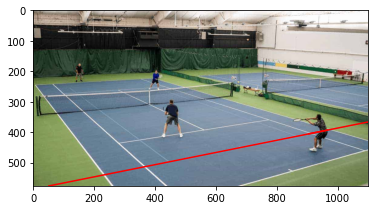

[25.82767476839338, 7.452490002546578]


In [75]:
target_lines_span = [[],[]]
target_thetas = [[],[]]
for i, parallel_lines in enumerate(target_lines):
    print('------------------')
    for line in parallel_lines:
        new_line, theta = find_line_eq(line)
        target_lines_span[i].append(new_line)
        target_thetas[i].append(theta)

target_thetas[0] = sum([abs(ele) for ele in target_thetas[0]]) / len(target_thetas[0])
target_thetas[1] = sum([abs(ele) for ele in target_thetas[1]]) / len(target_thetas[1])
print(target_thetas)
# for line in target_lines[1]:
#     new_line = find_line_eq(line)
#     target_lines_span[1].append(new_line)

In [76]:
target_lines_span_flip = copy.deepcopy(target_lines_span)
for i, target_line in enumerate(target_lines_span_flip):
    for j, point in enumerate(target_line):
        for k, coord in enumerate(point):
            coord = [coord[1],coord[0]]
            target_lines_span_flip[i][j][k] = coord

In [77]:
mid_pts = []
for vert in target_lines[0]:
    mid_pts.append((vert[0][1]+vert[1][1])/2)
    
print(mid_pts)
l1 = np.argmin(mid_pts)
l2 = np.argmax(mid_pts)
print(l1,l2)
mid_pts = []
for hor in target_lines[1]:
    print(hor)
    mid_pts.append((hor[0][0]+hor[1][0])/2)
print(mid_pts)
l3 = np.argmin(mid_pts)
l4 = np.argmax(mid_pts)
print(l3,l4)

[420.03261148929596, 791.2960761252584, 301.0478377342224, 249.72292929887772, 399.6990516781807, 771.4511093821106, 134.44157717749476, 486.08418107032776, 746.0786387324333, 609.9644752502468, 527.8275370686741]
6 1
[array([265.37584564, 537.68903613]), array([284.45260879, 321.99326754])]
[array([280.94162785, 321.74019295]), array([295.11596596, 125.09527802])]
[array([361.7630617 , 857.02599883]), array([356.86572677, 950.03712177])]
[array([284.91665843, 650.50908327]), array([345.46299577,  20.1785434 ])]
[array([513.72994614, 366.83399975]), array([407.18211341, 906.35974407])]
[array([437.44084609, 281.40495718]), array([362.87832159, 775.8777678 ])]
[array([245.72836643,   7.24011119]), array([225.37599126, 393.100366  ])]
[array([ 463.29047096, 1098.84120226]), array([579.0948782 , 675.47621131])]
[array([405.68040474, 906.05883261]), array([393.53985196, 966.64666533])]
[274.91422721743584, 288.0287969062732, 359.31439423561096, 315.1898270994425, 460.4560297727585, 400.159

In [78]:
# check if left
def check_side (line1,line2):
    plt.figure()
    print('line1:',line1)
    print('line2:',line2)
    plt.plot((line1[0][1], line1[1][1]),(line1[0][0], line1[1][0] ), c=[0.9,0,0])
    plt.plot((line2[0][1], line2[1][1]),(line2[0][0], line2[1][0] ), c=cc)
    plt.gca().invert_yaxis()
    # plt.text((vert[0][1]+vert[1][1])/2+(i*num),(vert[0][0]+vert[1][0])/2+(i*num),str(i),fontsize=20)
    inter = intersect(line1[0],line1[1],line2[0],line2[1])
    x_1 = line1[0][0]
    x_2 = line1[1][0]
    y_1 = line1[0][1]
    y_2 = line1[1][1]
    fx = x_2 - x_1
    fy = y_2 -y_1
    check = []

    if inter is not None:
        # mid_x1, mid_y1 = midpoint(line1)
        mid_x2, mid_y2 = midpoint(line2)
        torque = fx*(mid_y2-y_1)-fy*(mid_x2-x_1)
        # print(torque)
        if  torque>=0:
            # "point on left side"
            return 1
        else:
            return -1

    for pt in line2:
        torque = fx*(pt[1]-y_1)-fy*(pt[0]-x_1)
        if  torque>=0:
            # "point on left side"
            check.append(1)
        else:
            check.append(0)
    # print(check)
    # print(all(check))
    if all(check) == True:
        return 1
    else:
        return -1
 

In [79]:
# check if left
def check_side_f (line1,line2):
    plt.figure()
    print('line1:',line1)
    print('line2:',line2)
    plt.plot((line1[0][1], line1[1][1]),(line1[0][0], line1[1][0] ), c=[0.9,0,0])
    plt.plot((line2[0][1], line2[1][1]),(line2[0][0], line2[1][0] ), c=cc)
    plt.gca().invert_yaxis()
    # plt.text((vert[0][1]+vert[1][1])/2+(i*num),(vert[0][0]+vert[1][0])/2+(i*num),str(i),fontsize=20)
    inter = intersect(line1[0],line1[1],line2[0],line2[1])
    x_1 = line1[0][0]
    x_2 = line1[1][0]
    y_1 = line1[0][1]
    y_2 = line1[1][1]
    fx = x_2 - x_1
    fy = y_2 -y_1
    check = []

    if inter is not None:
        # mid_x1, mid_y1 = midpoint(line1)
        mid_x2, mid_y2 = midpoint(line2)
        torque = fy*(mid_y2-y_1)-fx*(mid_x2-x_1)
        # print(torque)
        if  torque>=0:
            # "point on left side"
            return 1
        else:
            return -1

    for pt in line2:
        torque = fy*(pt[1]-y_1)-fx*(pt[0]-x_1)
        if  torque>=0:
            # "point on left side"
            check.append(1)
        else:
            check.append(0)
    # print(check)
    # print(all(check))
    if all(check) == True:
        return 1
    else:
        return -1
 

In [80]:
# def make_comparator(less_than):
#     def compare(x, y):
#         if less_than(x, y):
#             return -1
#         elif less_than(y, x):
#             return 1
#         else:
#             return 0
#     return compare

In [81]:
print(target_lines_span[0])
print(target_lines_span_flip[0])

[[[128.69854085871137, 0.0], [577, 941.2003723791165]], [[113.70678038166552, 0.0], [498.8011975092275, 1100.0]], [[164.30999952017365, 0.0], [577, 549.3830436108942]], [[185.53197876181517, 0.0], [577, 435.0248885873775]], [[112.42640732960159, 0.0], [471.0021419363193, 1100.0]], [[116.45913678057876, 0.0], [463.6562265971552, 1100.0]], [[236.29755209083814, 0.0], [577, 261.55997957445413]], [[116.92282185219763, 0.0], [500.7188712344291, 1100.0]], [[109.36999263599287, 0.0], [433.98581474931734, 1100.0]], [[114.51274742040948, 0.0], [466.6328144234953, 1100.0]], [[119.35041261171479, 0.0], [497.2477132436449, 1100.0]]]
[[[0.0, 128.69854085871137], [941.2003723791165, 577]], [[0.0, 113.70678038166552], [1100.0, 498.8011975092275]], [[0.0, 164.30999952017365], [549.3830436108942, 577]], [[0.0, 185.53197876181517], [435.0248885873775, 577]], [[0.0, 112.42640732960159], [1100.0, 471.0021419363193]], [[0.0, 116.45913678057876], [1100.0, 463.6562265971552]], [[0.0, 236.29755209083814], [26

In [82]:
# print(tls, '\n')
# # print(tls[0],'\n')
# tls1 = tls
# # print(tls1[0][0][:, [1, 0]]) #= tls1[:, [0, 1]]
# # print(tls1[0][:,[1,0]],'\n')
# print('--------------')
# # tls1[:, [1, 0]] = tls1[:, [0, 1]]
# for i, t in enumerate(tls1):
#     tls1[i] = t[:,[1,0]]
# print(tls1)

line1: [[113.70678038166552, 0.0], [498.8011975092275, 1100.0]]
line2: [[128.69854085871137, 0.0], [577, 941.2003723791165]]
line1: [[164.30999952017365, 0.0], [577, 549.3830436108942]]
line2: [[113.70678038166552, 0.0], [498.8011975092275, 1100.0]]
line1: [[164.30999952017365, 0.0], [577, 549.3830436108942]]
line2: [[128.69854085871137, 0.0], [577, 941.2003723791165]]
line1: [[185.53197876181517, 0.0], [577, 435.0248885873775]]
line2: [[128.69854085871137, 0.0], [577, 941.2003723791165]]
line1: [[185.53197876181517, 0.0], [577, 435.0248885873775]]
line2: [[164.30999952017365, 0.0], [577, 549.3830436108942]]
line1: [[112.42640732960159, 0.0], [471.0021419363193, 1100.0]]
line2: [[164.30999952017365, 0.0], [577, 549.3830436108942]]
line1: [[112.42640732960159, 0.0], [471.0021419363193, 1100.0]]
line2: [[128.69854085871137, 0.0], [577, 941.2003723791165]]
line1: [[112.42640732960159, 0.0], [471.0021419363193, 1100.0]]
line2: [[113.70678038166552, 0.0], [498.8011975092275, 1100.0]]
line1:

/home/parallels/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


line1: [[119.35041261171479, 0.0], [497.2477132436449, 1100.0]]
line2: [[113.70678038166552, 0.0], [498.8011975092275, 1100.0]]
line1: [[224.84397768358696, 1100.0], [304.13294342998705, 0.0]]
line2: [[215.64342322948158, 1100.0], [312.9306329188395, 0.0]]
line1: [[348.96969864880896, 1100.0], [406.88823845581703, 0.0]]
line2: [[224.84397768358696, 1100.0], [304.13294342998705, 0.0]]
line1: [[241.7408531155502, 1100.0], [347.40124374798717, 0.0]]
line2: [[348.96969864880896, 1100.0], [406.88823845581703, 0.0]]
line1: [[241.7408531155502, 1100.0], [347.40124374798717, 0.0]]
line2: [[224.84397768358696, 1100.0], [304.13294342998705, 0.0]]
line1: [[241.7408531155502, 1100.0], [347.40124374798717, 0.0]]
line2: [[348.96969864880896, 1100.0], [406.88823845581703, 0.0]]
line1: [[368.94121422088296, 1100.0], [577, 46.45373457064882]]
line2: [[241.7408531155502, 1100.0], [347.40124374798717, 0.0]]
line1: [[368.94121422088296, 1100.0], [577, 46.45373457064882]]
line2: [[348.96969864880896, 1100.

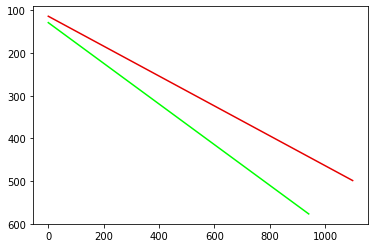

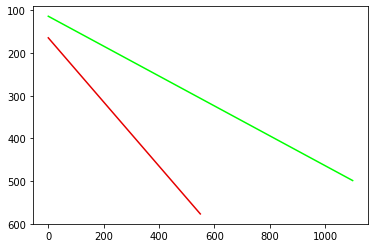

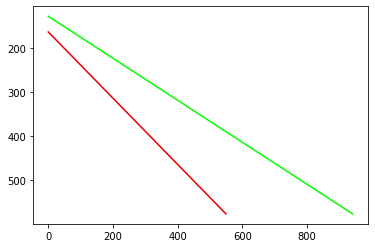

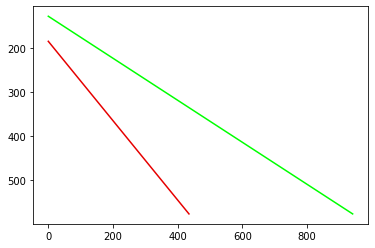

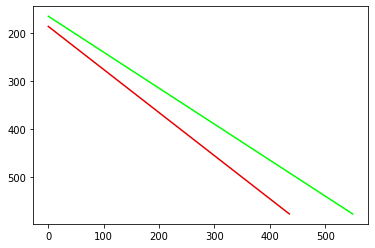

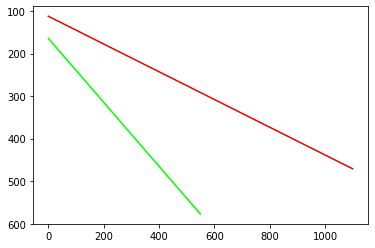

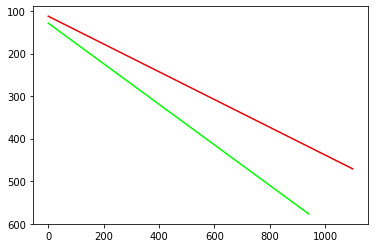

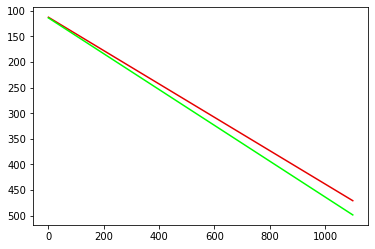

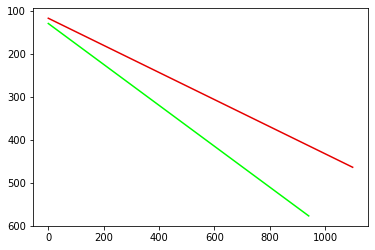

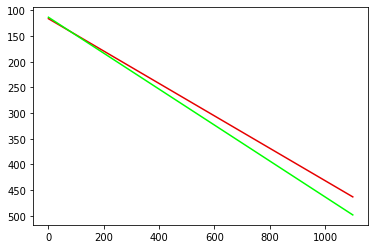

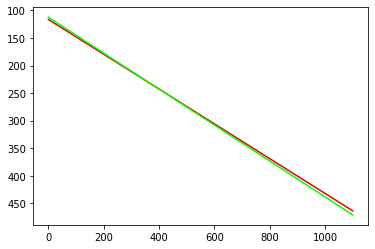

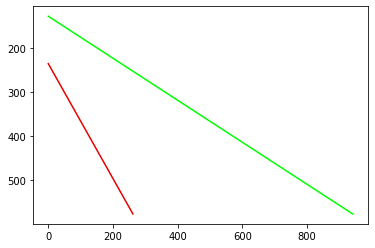

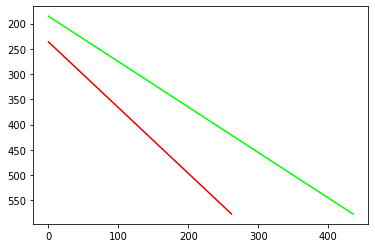

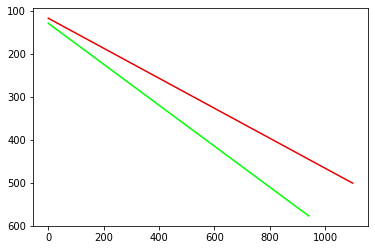

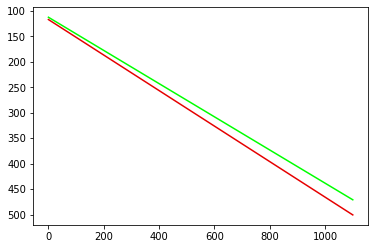

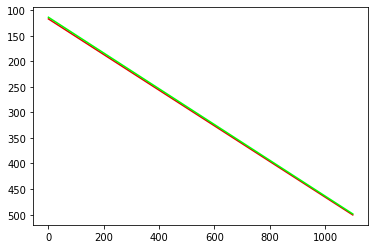

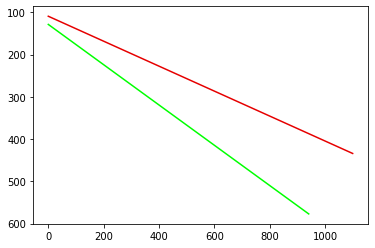

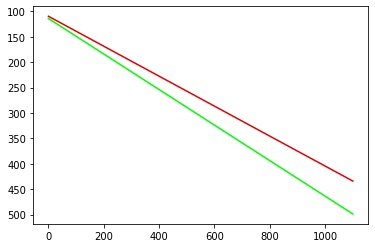

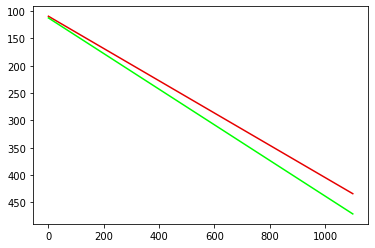

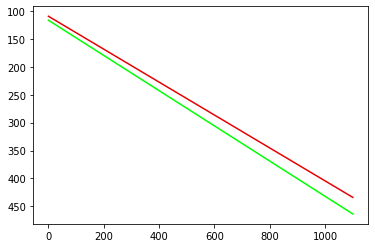

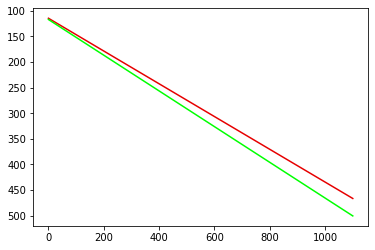

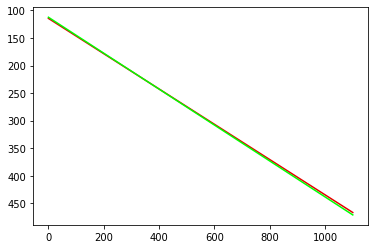

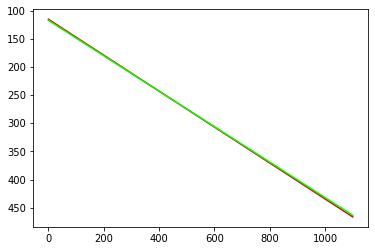

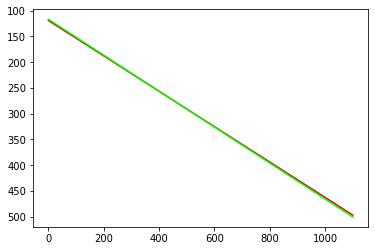

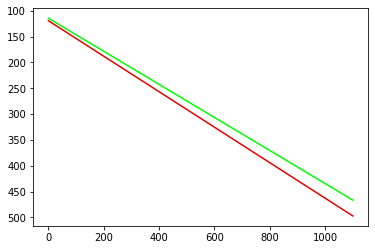

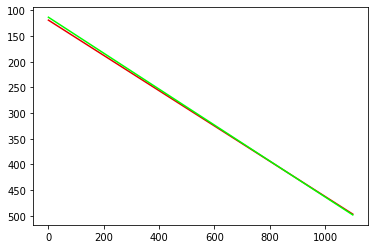

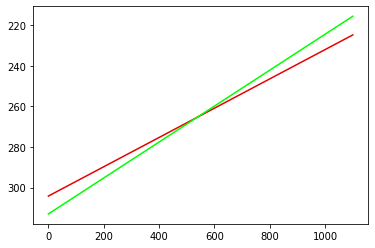

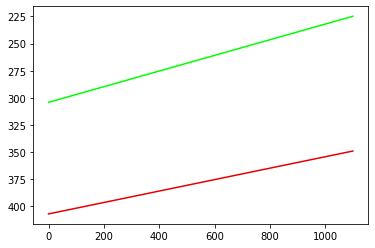

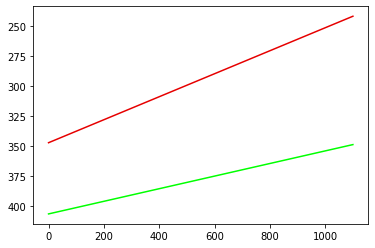

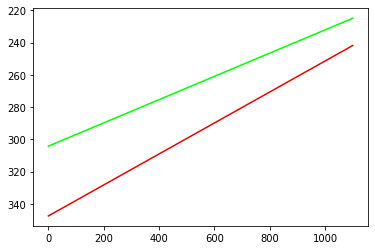

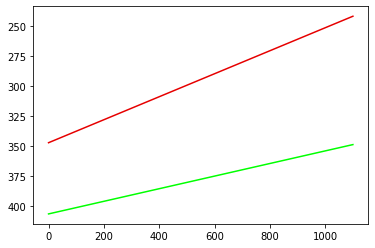

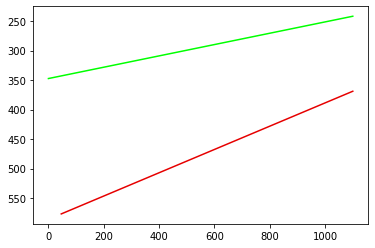

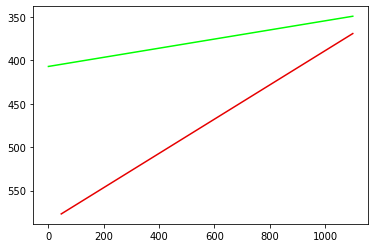

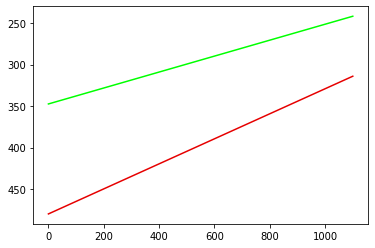

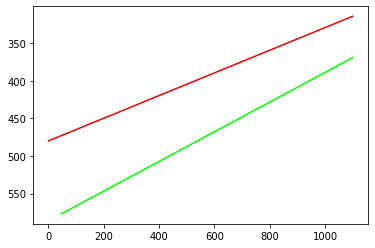

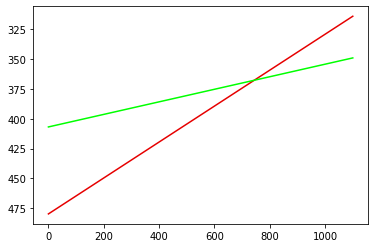

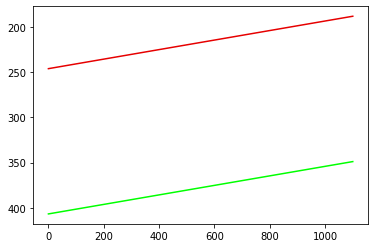

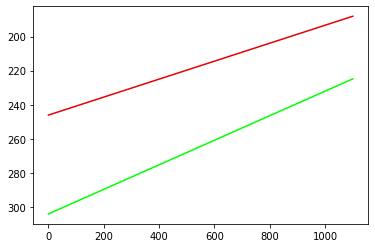

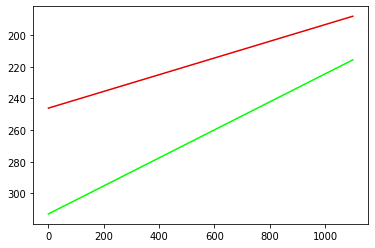

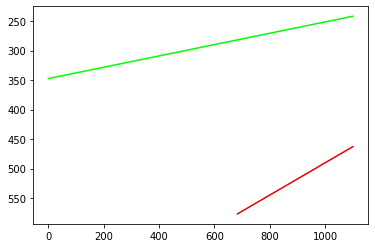

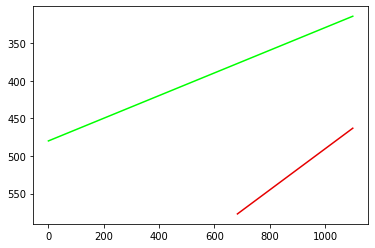

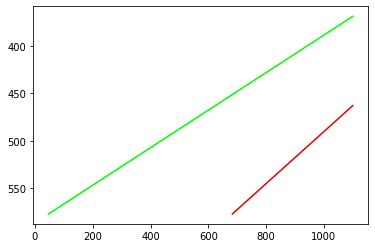

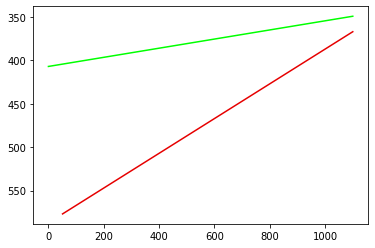

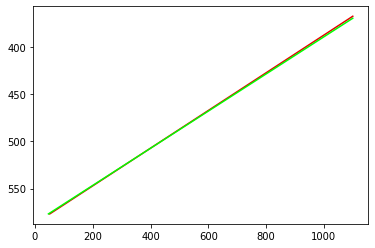

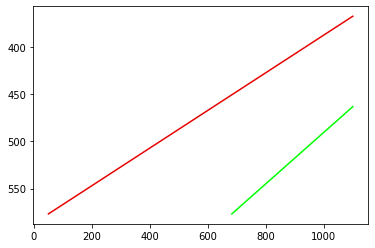

In [83]:
your_key = cmp_to_key(check_side)
your_key_f = cmp_to_key(check_side_f)
# trial = sorted(target_lines[0], key=make_comparator(check_side), reverse=True)
borders = []
# tls = np.concatenate([np.array(i) for i in target_lines_span])
# tls = np.hstack(target_lines_span)
for i in range(len(target_lines_span)):
   if target_thetas[i] > 20:
      # for j, t in enumerate(tls):
      #    tls[j] = t[:,[1,0]]
      borders.append(sorted(target_lines_span[i], key=your_key))
   else:
      borders.append(sorted(target_lines_span[i], key=your_key_f))
# trial2 = sorted(target_lines_span[1], key=your_key)
# trial = target_lines_span[0].sort(key=your_key)
# print(borders)
num = 1
# for border in borders:
#    for i, vert in enumerate(border):
#       plt.plot((vert[0][1], vert[1][1]),(vert[0][0], vert[1][0] ), c=cc)
#       plt.text((vert[0][1]+vert[1][1])/2+(i*num),(vert[0][0]+vert[1][0])/2+(i*num),str(i),fontsize=20)
# plt.imshow(im)

In [84]:
len(borders)

2

In [85]:
def order_points3(pts):
	# sort the points based on their x-coordinates
	xSorted = pts[np.argsort(pts[:, 0]), :]
	# grab the left-most and right-most points from the sorted
	# x-roodinate points
	leftMost = xSorted[:2, :]
	rightMost = xSorted[2:, :]
	# now, sort the left-most coordinates according to their
	# y-coordinates so we can grab the top-left and bottom-left
	# points, respectively
	leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
	(tl, bl) = leftMost
	# now that we have the top-left coordinate, use it as an
	# anchor to calculate the Euclidean distance between the
	# top-left and right-most points; by the Pythagorean
	# theorem, the point with the largest distance will be
	# our bottom-right point
	D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
	(br, tr) = rightMost[np.argsort(D)[::-1], :]
	# return the coordinates in top-left, top-right,
	# bottom-right, and bottom-left order
	return np.array([tl,bl,br,tr], dtype="float32")
	[tl, tr, br, bl]

0
1


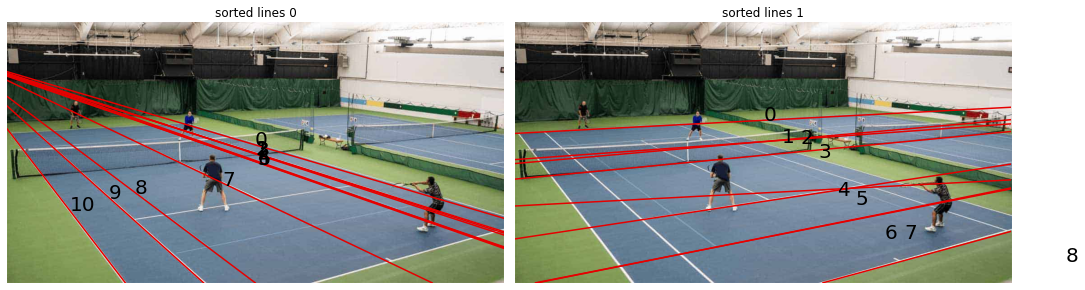

In [86]:

fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()
for j in range(len(borders)):
    if j == 0:
        num = 1
        num1 = 1
        st = -1
    else:
        num = 41
        num1 = 1
        st = 1
    ax[j].imshow(im)
    print(j)
    for i, vert in enumerate(borders[j]):
        cx=[0.9,0,0]
        ax[j].plot((vert[0][1], vert[1][1]),(vert[0][0], vert[1][0] ), c=cx)
        ax[j].text(st+(vert[0][1]+vert[1][1])/2+(i*num),(vert[0][0]+vert[1][0])/2+(i*num1),str(i),fontsize=20)
    ax[j].set_xlim((0, im.shape[1]))
    ax[j].set_ylim((im.shape[0], 0))
    ax[j].set_title('sorted lines {}'.format(str(j)))

for a in ax:
    a.set_axis_off()

plt.tight_layout() 
plt.show()
# plt.savefig(fig_name)
plt.close()

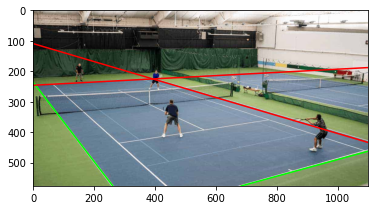

In [87]:
borders_filtered = []
for i in borders:
    borders_filtered.append(i[0])
    borders_filtered.append(i[-1])
    plt.plot((i[0][0][1], i[0][1][1]),(i[0][0][0], i[0][1][0] ), c=[1,0,0])
    plt.plot((i[-1][0][1], i[-1][1][1]),(i[-1][0][0], i[-1][1][0] ), c=[0,1,0])
# plt.plot((borders[1][0][0][1], borders[1][0][1][1]),(borders[1][0][0][0], borders[1][0][1][0] ), c=cc)
# plt.plot((borders[1][-1][0][1], borders[1][-1][1][1]),(borders[1][-1][0][0], borders[1][-1][1][0] ), c=cc)
plt.imshow(im)

In [147]:
borders[1]

[[[188.0902475525648, 1100.0], [246.11024940266768, 0.0]],
 [[215.64342322948158, 1100.0], [312.9306329188395, 0.0]],
 [[224.84397768358696, 1100.0], [304.13294342998705, 0.0]],
 [[241.7408531155502, 1100.0], [347.40124374798717, 0.0]],
 [[348.96969864880896, 1100.0], [406.88823845581703, 0.0]],
 [[314.00329477330615, 1100.0], [479.87445125493207, 0.0]],
 [[368.94121422088296, 1100.0], [577, 46.45373457064882]],
 [[366.81859252469826, 1100.0], [577, 51.08268995896659]],
 [[462.9735012310014, 1100.0], [577, 683.1347979724032]]]

In [150]:
borders_filtered_mod[1]

[[[188.0902475525648, 1100.0], [246.11024940266768, 0.0]],
 [[215.64342322948158, 1100.0], [312.9306329188395, 0.0]],
 [[462.9735012310014, 1100.0], [577, 683.1347979724032]]]

2
2
[[109.36999263599287, 0.0], [433.98581474931734, 1100.0]]


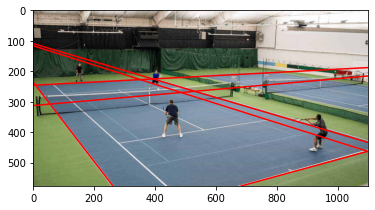

In [194]:
borders_filtered_mod = [[],[]]
vert_len = math.ceil(math.ceil(0.1*len(borders[0])) / 2.) * 2
hor_len = math.ceil(math.ceil(0.1*len(borders[1])) / 2.) * 2
print(vert_len)
print(hor_len)
for j in range(vert_len):
    borders_filtered_mod[0].append(borders[0][j])
    if j!=0:
        borders_filtered_mod[0].append(borders[0][-j])
for j in range(hor_len):
    borders_filtered_mod[1].append(borders[1][j])
    if j!=0:
        borders_filtered_mod[1].append(borders[1][-j])

print(borders_filtered_mod[0][0])

for i in borders_filtered_mod:
    for j in range(len(i)):
        plt.plot((i[j][0][1], i[j][1][1]),(i[j][0][0], i[j][1][0] ), c=[1,0,0])
    plt.imshow(im)

In [88]:
borders_filtered[0][0]

[109.36999263599287, 0.0]

In [89]:
ptt_int = []
for i in range(2):
    for j in range(2,4):
        ptt = get_intersect(borders_filtered[i][0],borders_filtered[i][1],borders_filtered[j][0],borders_filtered[j][1])
        ptt_int.append(ptt)
# for j, i in enumerate(ptt_int):
#     plt.scatter(i[1],i[0], c = 'r',s=36)
#     plt.text(i[1],i[0],s=str(j+1) ,fontsize=20)
# plt.imshow(im)
# plt.gca().set_ylim(700)
# plt.gca().set_xlim(0,1200)
box = order_points3(np.array(ptt_int))
# print(box[:,1],box[:,0])
box[:,[0,1]]= box[:,[1,0]]
print(box)

# plt.figure(222)
# for j, i in enumerate(box):
#     plt.scatter(i[0],i[1], c = 'r',s=36)
#     plt.text(i[0],i[1],s=str(j+1) ,fontsize=20)
# plt.imshow(im)
# plt.gca().set_ylim(700)
# plt.gca().set_xlim(0,1200);

[[   7.2401114  245.72836  ]
 [ 393.10037    225.37599  ]
 [1150.9773     449.0295   ]
 [ 334.72403    672.30194  ]]


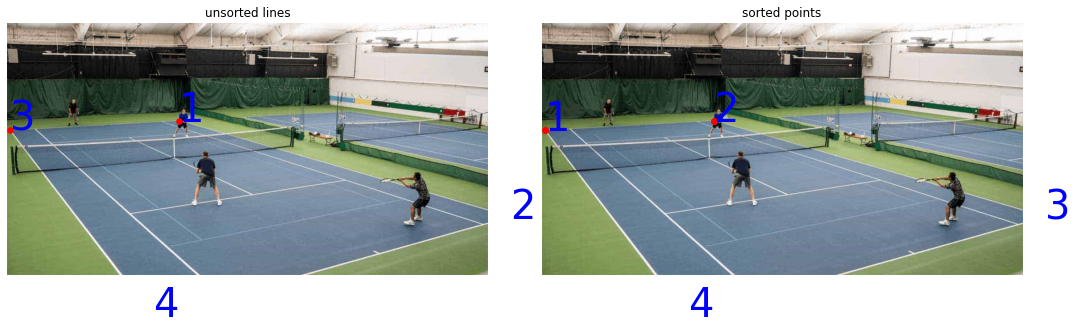

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

for j, i in enumerate(ptt_int):
    ax[0].scatter(i[1],i[0], c = 'r',s=30)
    ax[0].text(i[1],i[0],s=str(j+1) , c= 'b',fontsize=40)
ax[0].imshow(im)
ax[0].set_xlim((0, im.shape[1]))
ax[0].set_ylim((im.shape[0], 0))
ax[0].set_title('unsorted lines')

for j, i in enumerate(box):
    ax[1].scatter(i[0],i[1], c = 'r',s=36)
    ax[1].text(i[0],i[1],s=str(j+1) ,c = 'b',fontsize=40)
ax[1].imshow(im)
ax[1].set_xlim((0, im.shape[1]))
ax[1].set_ylim((im.shape[0], 0))
ax[1].set_title('sorted points')

for a in ax:
    a.set_axis_off()

plt.tight_layout() 
plt.show()
# plt.savefig(fig_name)
plt.close()

In [91]:
def add_court_overlay(frame, homography,template_try, overlay_color=(255, 255, 255)):
    court_reference = cv2.imread("pictures/court_reference.png", 0)
    # court_reference = cv2.rotate(court_reference, cv2.cv2.ROTATE_90_CLOCKWISE)
    # cv2.imshow('fort',court_reference)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # court = cv2.warpPerspective(court_reference, homography, (frame.shape[1],frame.shape[0]))
    print(frame.shape)
    f = 3
    court = cv2.warpPerspective(frame, homography,(frame.shape[1]*f,frame.shape[0]*f), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    
    frame = court 
    # frame[court == 255, :] = overlay_color
    return frame

In [92]:
factor_s = 1
width = court_reference.shape[1]
height = court_reference.shape[0]
# template_try= np.asarray([[0, 0], [width/factor_s, 0], [height/factor_s,0], [ width*factor_s,height/factor_s]])
# template_try= np.asarray([[0, 0], [2408/factor_s, 0], [2408/factor_s, 1127*factor_s], [0, 1127*factor_s]])
template_try= np.asarray([[0, 0], [width/factor_s, 0], [width/factor_s, height*factor_s], [0, height*factor_s]])


In [93]:
box = np.asarray(box)

print(box)
# template_try[:,[0,1]]= template_try[:,[1,0]]
print(template_try)

[[   7.2401114  245.72836  ]
 [ 393.10037    225.37599  ]
 [1150.9773     449.0295   ]
 [ 334.72403    672.30194  ]]
[[   0.    0.]
 [1127.    0.]
 [1127. 2408.]
 [   0. 2408.]]


In [94]:
box = np.float32(box).reshape(-1,1,2)
template_try = np.float32(template_try).reshape(-1,1,2)

In [212]:
def get_confi_score(matrix,court_reference):
    """
    Calculate transformation score
    """
    court = cv2.warpPerspective(court_reference, matrix, (im.shape[1],im.shape[0]))
    

    court[court > 0] = 1
    kernel = np.ones((5,5),np.uint8)
    gray1 = gray.copy()
    gray1 = cv2.dilate(gray1,kernel,iterations=1)
    gray1[gray1 > 0] = 1 
    correct = court * gray1
    # plt.figure()
    # plt.imshow(correct)
    wrong = court - correct
    c_p = np.sum(correct)
    w_p = np.sum(wrong)
    return c_p - (0.1* w_p)
    # return c_p - 0.5 * w_p

16.4
202.3
286.6
2598.5


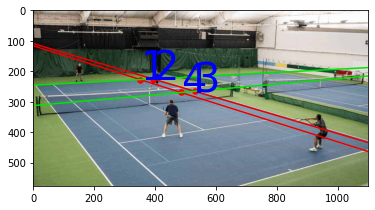

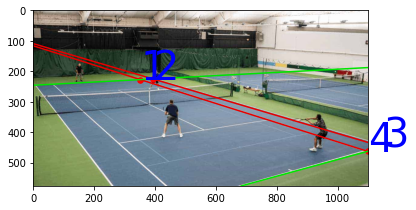

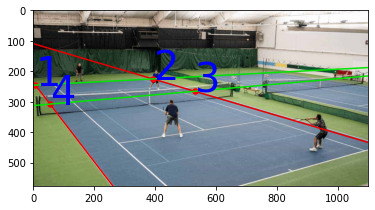

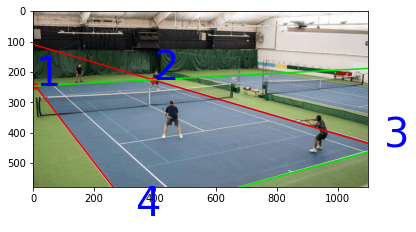

In [213]:
# for trying the scores

max_score = -np.inf
max_mat = None
max_inv_mat = None
k = 0
best_conf = None
# Loop over every pair of horizontal lines and every pair of vertical lines
for horizontal_pair in list(combinations(borders_filtered_mod[0], 2)):
    for vertical_pair in list(combinations(borders_filtered_mod[1], 2)):
        h1, h2 = horizontal_pair
        v1, v2 = vertical_pair
        
        # Finding intersection points of all lines
        i1 = get_intersect(h1[0],h1[1], v1[0], v1[1])
        i2 = get_intersect(h1[0],h1[1], v2[0], v2[1])
        i3 = get_intersect(h2[0],h2[1], v1[0], v1[1])
        i4 = get_intersect(h2[0],h2[1], v2[0], v2[1])

        intersections = np.array([i1, i2, i3, i4])
        intersections = order_points3(intersections)
        intersections[:,[0,1]]= intersections[:,[1,0]]
        
        if k < 15 & False:
            plt.figure()
            plt.plot((h1[0][1], h1[1][1]),(h1[0][0], h1[1][0] ), c=[0.9,0,0])
            plt.plot((h2[0][1], h2[1][   1]),(h2[0][0], h2[1][0] ), c=[0.9,0,0])
            plt.plot((v1[0][1], v1[1][1]),(v1[0][0], v1[1][0] ), c=[0,0.9,0])
            plt.plot((v2[0][1], v2[1][1]),(v2[0][0], v2[1][0] ), c=[0,0.9,0])
            for j, i in enumerate(intersections):
                plt.scatter(i[1],i[0], c = 'r',s=30)
                plt.text(i[1],i[0],s=str(j+1) , c= 'b',fontsize=40)
            plt.imshow(im)
        
        T= cv2.getPerspectiveTransform(template_try,intersections)
        inv_T = cv2.invert(T)[1]
        confi_score = get_confi_score(T,court_reference)
        # for i, configuration in court_reference.court_conf.items():
        #     # Find transformation
        #     matrix, _ = cv2.findHomography(np.float32(configuration), np.float32(intersections), method=0)
        #     inv_matrix = cv2.invert(matrix)[1]
        #     # Get transformation score
        #     confi_score = get_confi_score(matrix,court_reference)

        if max_score < confi_score:
            max_score = confi_score
            print(max_score)
            max_mat = T
            max_inv_mat = inv_T
            best_int_pts = intersections
            plt.figure()
            plt.plot((h1[0][1], h1[1][1]),(h1[0][0], h1[1][0] ), c=[0.9,0,0])
            plt.plot((h2[0][1], h2[1][   1]),(h2[0][0], h2[1][0] ), c=[0.9,0,0])
            plt.plot((v1[0][1], v1[1][1]),(v1[0][0], v1[1][0] ), c=[0,0.9,0])
            plt.plot((v2[0][1], v2[1][1]),(v2[0][0], v2[1][0] ), c=[0,0.9,0])
            for j, i in enumerate(intersections):
                plt.scatter(i[0],i[1], c = 'r',s=30)
                plt.text(i[0],i[1],s=str(j+1) , c= 'b',fontsize=40)
            plt.imshow(im)
        
        k += 1

In [217]:
T_T= cv2.getPerspectiveTransform(best_int_pts,template_try)
T_T = scaleHToImage(T_T, im.shape, False)

Scaling by 5.643143



(577, 1100, 3)


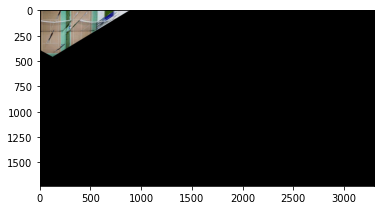

In [218]:
im7 = np.copy(im)
court = add_court_overlay(im7, T_T, template_try,overlay_color=(255, 0, 0))
court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
cv2.imshow("Court", court)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(court)
plt.show()
plt.close()

In [96]:
def getHCorners_try(H, limits):
    Ny = float(limits[0])
    Nx = float(limits[1])
    print('ny', Ny, 'nx', Nx)
    # Apply H to corners of the image to determine bounds
    Htl  = np.dot(H, np.array([0.0, 0.0, 1.0]).flatten())  # Top left maps to here
    Htr  = np.dot(H, np.array([Nx , 0.0, 1.0]).flatten())  # top right maps to here
    Hbr  = np.dot(H, np.array([Nx , Ny , 1.0]).flatten())  # Bottom right maps to here
    Hbl  = np.dot(H, np.array([0.0, Ny , 1.0]).flatten())  # Bottom left maps to here
    Hcor = [Htl,Htr,Hbr,Hbl]
    print('Hcor', Hcor)


    # Check if corners in the transformed image map to infinity finite
    finite = True 
    for y in Hcor:
        if y[2] == 0:
            finite = False

    return Hcor, finite

In [97]:
im6 = np.copy(im)
# T, status = cv2.findHomography(box,template_try)
T= cv2.getPerspectiveTransform(box,template_try)
H = T
print(H)
# H = rotateHToLine(H, [inlier_lines_list[0],1])
# H = translateHToPosQuadrant(T, im.shape)
H = scaleHToImage(H, im.shape, False)

[[-5.35615072e+00  4.11195938e+00 -9.71645920e+02]
 [-2.26144832e+00 -4.28747603e+01  1.05519178e+04]
 [ 2.71940909e-04 -1.33775864e-02  1.00000000e+00]]
Scaling by 5.643143



In [98]:
Hcor1, finite1 = getHCorners_try(T, im.shape)
for h in Hcor1:
    h = [h[0]/h[2],h[1]/h[2]]
    print(h)
k = [max([Hcor1[j][i] / Hcor1[j][2] for j in range(len(Hcor1))])/float(im.shape[i]) for i in range(2)]


ny 577.0 nx 1100.0
Hcor [array([-9.71645920e+02,  1.05519178e+04,  1.00000000e+00]), array([-6.86341171e+03,  8.06432465e+03,  1.29913500e+00]), array([-4.49081115e+03, -1.66744120e+04, -6.41973235e+00]), array([ 1.40095464e+03, -1.41868189e+04, -6.71886735e+00])]
[-971.6459196874391, 10551.917796513433]
[-5283.062743473336, 6207.457003343279]
[699.5324581647616, 2597.3687253253674]
[-208.51053752709558, 2111.4896524501323]


[[[-172.1817   1869.8655  ]]

 [[-936.1916   1100.      ]]

 [[ 123.9615    460.2699  ]]

 [[ -36.949364  374.1691  ]]]
[[   1.    0.  937.]
 [   0.    1. -374.]
 [   0.    0.    1.]]
[-172.1817 1869.8655]
[-936.1916 1100.    ]
[123.9615 460.2699]
[-36.949364 374.1691  ]


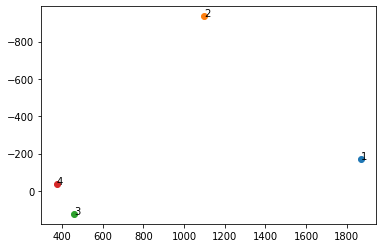

In [99]:
h, w = im.shape[:2]
corners_bef = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)

corners_aft = cv2.perspectiveTransform(corners_bef, H)
print(corners_aft)
xmin = math.floor(corners_aft[:, 0, 0].min())
ymin = math.floor(corners_aft[:, 0, 1].min())
xmax = math.ceil(corners_aft[:, 0, 0].max())
ymax = math.ceil(corners_aft[:, 0, 1].max())
x_adj = math.floor(xmin - corners_aft[0, 0, 0])
y_adj = math.floor(ymin - corners_aft[0, 0, 1])
translate = np.eye(3)
translate[0, 2] = -xmin
translate[1, 2] = -ymin
corrected_transform = np.matmul(translate, H)
print(translate)
for i, h in enumerate(corners_aft):
    h = h[0]
    print(h)
    plt.scatter(h[1],h[0])
    plt.text(h[1],h[0],str(i+1))
plt.gca().invert_yaxis()

ny 577.0 nx 1100.0
Hcor [array([-1.72181702e+02,  1.86986548e+03,  1.00000000e+00]), array([-1.21623926e+03,  1.42904850e+03,  1.29913500e+00]), array([ -795.79967514, -2954.80954987,    -6.41973235]), array([  248.25787855, -2513.99256802,    -6.71886735])]
x_max 123.96150365065755 -936.1915861343413 1869.865481132337 374.16910281363107
HT [[  1.           0.         936.19158613]
 [  0.           1.         374.16910281]
 [  0.           0.           1.        ]]
Scaling by 1.837354



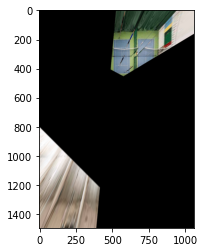

In [100]:
Hcor, finite = getHCorners_try(H, im.shape)
# print(Hcor[0])
x_max, x_min = -np.inf, np.inf
y_max, y_min = -np.inf, np.inf
# plt.imshow(im)

hh = []
for i,h in enumerate(Hcor):
    h = [h[0]/h[2],h[1]/h[2]]
    # if h[0]> im.shape[1]:
    #     h[0] = im.shape[1]
    #     # h[0]= h[0]/ im.shape[1]
    # if h[1]> im.shape[0]:
    #     h[1] = im.shape[0]
        # h[1]= h[1]/ im.shape[0]
    if h[0]> x_max:
        x_max = h[0]
    if h[0]< x_min:
        x_min = h[0]
    if h[1]> y_max:
        y_max = h[1]
    if h[1]< y_min:
        y_min = h[1]
    hh.append(h)

# x_max = x_max / im.shape[1]
# y_max = y_max / im.shape[0]
# x_min = x_min / im.shape[1]
# y_min = y_min / im.shape[0]
print('x_max' , x_max,x_min,y_max,y_min)

HT = np.identity(3)
HT[0,2] = abs(x_min)
HT[1,2] = abs(y_min)
print('HT',HT)

HH = np.dot(HT,H)
HH = scaleHToImage(HH, im.shape, False)

x_size = int(x_max-x_min)
y_size = int(y_max-y_min)
s_limit = 2000
if  x_size > s_limit:
    x_size = s_limit
if y_size > s_limit:
    y_size = s_limit

court = cv2.warpPerspective(im6, HH, (x_size,y_size))
# court = cv2.warpPerspective(im6, H, (im.shape[0],im.shape[1]))
# court = cv2.warpPerspective(im6, corrected_transform, (math.ceil(xmax - xmin), math.ceil(ymax - ymin)))
plt.imshow(court) 

# for i, h in enumerate(hh):
#     print(h)
#     plt.scatter(h[1],h[0])
#     plt.text(h[1],h[0],str(i+1))
    


# ss = cv2.warpPerspective(im6, HH,(int(x_max-x_min),int(y_max-y_min)))
# ss = cv2.cvtColor(ss, cv2.COLOR_RGB2BGR)
ccs = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
cv2.imshow("Court", ccs)
cv2.waitKey(0)
cv2.destroyAllWindows()
# plt.imshow(ss)
# plt.show()
# plt.close()

(577, 1100, 3)


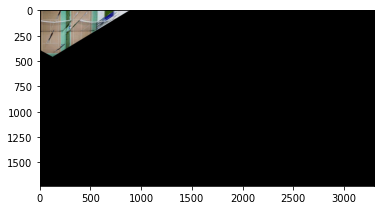

In [215]:

court = add_court_overlay(im6, H, template_try,overlay_color=(255, 0, 0))
court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
cv2.imshow("Court", court)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(court)
plt.show()
plt.close()

In [102]:
def order_points(pts):
    # initialize a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype="float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum

	s = pts.sum(axis=1)
	diff = np.diff(pts, axis=1)
	pt1= np.argmin(s)
	pt2= np.argmin(diff)
	rect[0] = pts[pt1]
	rect[1] = pts[pt2]
	# print(pts.shape)
	# print('pts',pts,'rect0',rect[0],'end')
	# print('pts reshape', pts.reshape(-1,1))
	# print(pts.reshape(-1,1).shape)
	# print('rect0 ', rect[0].shape)
	# print('rect0 reshape ', rect[0].reshape(-1,1).shape)
	D1 = dist.cdist(rect[0].reshape(-1,2),pts, "euclidean")
	print('D1', D1)
	pt3 = np.argmax(D1)
	print('argmax ', pt3)
	rect[2] = pts[pt3]

	D2 = dist.cdist(rect[1].reshape(-1,2),pts, "euclidean")
	D3 = dist.cdist(rect[2].reshape(-1,2),pts, "euclidean")
	
	print('D2', D2)
	D4 = D2*D3
	D4 = np.delete(D4,[pt1,pt2,pt3])
	# D3 = np.delete(D3,pt2)
	print('argmax ', np.argmax(D4))
	rect[3] = pts[np.argmax(D4)]
	# # now, compute the difference between the points, the
	# # top-right point will have the smallest difference,
	# # whereas the bottom-left will have the largest difference

	# rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [103]:
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

In [104]:
def order_points2(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost, rightMost = split_list(xSorted)
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :][-2:]
    (tl, bl) = leftMost
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :][-2:]
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    print(tl,tr,br,bl)
    return np.array([tl, tr, br, bl], dtype="float32")

D1 [[3.21275249e+02 3.14659967e+02 5.35573888e+02 3.80453193e+02
  7.02700163e+02 5.72672727e+02 2.14986108e+02 8.87323392e+02
  7.01236903e+02 4.47876385e+02 4.44583076e+02 7.31120389e+02
  5.19119965e+02 8.72337536e+02 7.34341236e+02 3.21888903e+02
  1.06119476e+03 8.69600902e+02 1.77420242e+02 1.69024490e+02
  3.28410734e+02 2.23988221e+02 5.05154858e+02 3.87671413e+02
  9.46412784e+01 6.79805255e+02 5.04860749e+02 1.33850836e+02
  1.25044665e+02 2.69944365e+02 1.77543483e+02 4.47291867e+02
  3.33624349e+02 5.64294131e+01 6.18676679e+02 4.47297994e+02
  4.77202604e+02 4.74954615e+02 7.79782513e+02 5.51638108e+02
  9.12235650e+02 7.72517502e+02 3.46225933e+02 1.10174206e+03
  9.09151324e+02 4.79594150e+02 4.77390756e+02 7.90460689e+02
  5.55781389e+02 9.22101307e+02 7.80674583e+02 3.45189230e+02
  1.11307062e+03 9.18901823e+02 7.85795015e+01 6.91466095e+01
  1.94819314e+02 1.18559836e+02 3.71131287e+02 2.63328599e+02
  3.40106559e-06 5.37783162e+02 3.71553882e+02 4.41793769e+02
  4.3

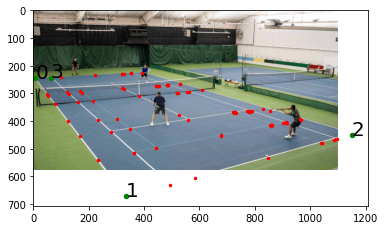

In [105]:
x_max, x_min = -math.inf, math.inf
y_max, y_min = -math.inf, math.inf
intersections = []
box = [[],[],[],[]]
for hor in target_lines[0]:
    for vert in target_lines[1]:
         ptt2 = get_intersect(hor[0],hor[1],vert[0],vert[1])
         if x_max <= ptt2[0]:
            x_max = ptt2[0]
         if x_min >= ptt2[0]:
            x_min = ptt2[0]
         if y_max <= ptt2[1]:
            y_max = ptt2[1]
         if y_min >= ptt2[1]:
            y_min = ptt2[1]
         intersections.append(ptt2)
         plt.scatter(ptt2[1],ptt2[0], c = 'r',s=6)
plt.imshow(im)
# plt.gca().set_ylim(-10,700)
# plt.gca().set_xlim(-100,1200)
# plt.gca().invert_yaxis()

box = order_points(np.array(intersections))
# box[0] = sorted(intersections, key=lambda p: (p[0]) + (p[1]))[0]  # find upper left point
# box[1] = sorted(intersections, key=lambda p: (p[0]) - (p[1]))[-1]  # find upper right point

# high_1 , high_2 = -math.inf, -math.inf
# for inter in intersections:
#    if inter not in (box[0],box[1]):
#       pt1_dist = np.linalg.norm(np.array(box[0])-np.array(inter))
#       pt2_dist = np.linalg.norm(np.array(box[1])-np.array(inter))
#       if pt1_dist >= high_1:
#          high_1 = pt1_dist
#          box[2] = inter
#       if pt2_dist >= high_2:
#          high_2 = pt2_dist
#          box[3] = inter      
      
# print(high_1, high_2)     
# plt.scatter(box[2][1],box[2][0],c='g',s = 30)
for i,j in enumerate(box):
   plt.scatter(j[1],j[0],c='g',s=20)
   plt.text(j[1],j[0],str(i),fontsize=20)
